# MARATONA BEHIND THE CODE 2020

## DESAFIO 6: LIT

## Testes com modelo LightGBM
- Autor: Rodrigo Lima
- LinkedIN: https://www.linkedin.com/in/rodrigolima82/


![title](virtual_assistance.png)

# Parte 01. Importando as bibliotecas

In [48]:
# Pacotes padrao
import pandas as pd
import numpy as np
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Pacote do sklearn
import lightgbm as lgbm
import optuna.integration.lightgbm as lgb2
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pacote imblearn
import imblearn
from imblearn.over_sampling import SMOTE

# Pacote LOFO para Feature Importance
from lofo import LOFOImportance, Dataset, plot_importance

# Pacote para hyperparametros
#import optuna

# Desativando warnings no jupyter
import warnings
warnings.filterwarnings('ignore')

# Parte 02. Carregando o Dataset

In [19]:
# Carregando o dataset da competição
dados = pd.read_csv('../data/training_dataset.csv')

# Visualizando os primeiros registros
print(dados.shape)
dados.head()

(15857, 15)


id       graduacao                           universidade  \
0  915132186.0  Especialização                                   UNIP   
1  183037660.0             MBA                                    NaN   
2  681614019.0     Bacharelado                                UNICAMP   
3  398921329.0    SEM FORMAÇÃO                                   UFRN   
4  522842284.0       Tecnólogo  INSPER INSTITUTO DE ENSINO E PESQUISA   

         profissao        organizacao  pretende_fazer_cursos_lit  \
0  Analista Senior   Eletrodomesticos                        1.0   
1       Supervisor         e-commerce                        0.0   
2           Outros         e-commerce                        1.0   
3           Outros  Eletroeletronicos                        NaN   
4  SEM EXPERIÊNCIA   Eletrodomesticos                        NaN   

   interesse_mba_lit  importante_ter_certificado  horas_semanais_estudo  \
0                1.0                         1.0                    6.0   
1                0.0                         1.0                    6.0   
2                1.0                         1.0                   10.0   
3                1.0                         1.0                    5.0   
4                0.0                         1.0                    7.0   

  como_conheceu_lit  total_modulos  modulos_iniciados  modulos_finalizados  \
0            Google           28.0                5.0                  4.0   
1               NaN           66.0               36.0                 34.0   
2        Saint Paul           27.0               27.0                 27.0   
3         Instagram           29.0               10.0                  6.0   
4            Google           67.0               49.0                 44.0   

   certificados categoria  
0           0.0   perfil6  
1           0.0   perfil2  
2           0.0   perfil2  
3           0.0   perfil5  
4           0.0   perfil2

# Parte 03. EDA (Análise Exploratória dos Dados)
> Nesta fase estou usando a biblioteca **Pandas Profile** pois automatiza o processo e nos traz uma visão geral do dataset
> Para mais detalhes, segue link da documentação: https://pandas-profiling.github.io/pandas-profiling/docs/master/index.html

### Dicionário de dados

- **id**
- **graduacao**
- **universidade**
- **profissao**
- **organizacao**
- **pretende_fazer_cursos_lit**
- **interesse_mba_lit**
- **importante_ter_certificado**
- **horas_semanais_estudo**
- **como_conheceu_lit**
- **total_modulos**
- **modulos_iniciados**
- **modulos_finalizados**
- **certificados**

A variável-alvo é:

- **categoria**

    > perfil1
    > perfil2
    > perfil3
    > perfil4
    > perfil5
    > perfil6

In [3]:
# Cria o objeto profile
profile = pp.ProfileReport(dados, title="Maratona IBM - Desafio 06", explorative=True)

# Executa o relatório e mostra no Jupyter
profile

In [ ]:
#profile.to_file('Desafio_6.html')

### Observações:
> - 
> - 

# Parte 04. Feature Engineering
> Nesta fase estarei trabalhando na manipulação dos dados
> Importante realizar o mínimo de alterações para não descaracterizar as informações
> Vou remover algumas colunas que identifiquei na análise exploratória e criar outras colunas que julgo interessante

**Agora a parte importante - decidir o que fazer!**

-
-

O que fazer?

**Decisão:**

- 1- 
- 2- 

**Alternativas:**

- 


In [20]:
# Remove as variáveis de ID e unique
dados.drop(['id','importante_ter_certificado'], axis = 1, inplace = True)

In [21]:
# Remove todos os registros que tem algum dado vazio de algumas colunas
dados.dropna(axis='index', how='any', subset=['pretende_fazer_cursos_lit',
                                              'interesse_mba_lit',
                                              'certificados'], inplace=True)

In [22]:
# Funcao para preencher os dados missing de algumas colunas
def preenche_missing(df):
    df['graduacao']             = df['graduacao'].fillna('Outros')
    df['universidade']          = df['universidade'].fillna('Outros')
    df['como_conheceu_lit']     = df['como_conheceu_lit'].fillna('Outros')
    df['organizacao']           = df['organizacao'].fillna('Outros')
    df['profissao']             = df['profissao'].fillna('Outros')
    df['horas_semanais_estudo'] = df['horas_semanais_estudo'].fillna(df['horas_semanais_estudo'].mean())
    df['total_modulos']         = df['total_modulos'].fillna(df['total_modulos'].median())
    df['modulos_iniciados']     = df['modulos_iniciados'].fillna(df['modulos_iniciados'].median())
    df['modulos_finalizados']   = df['modulos_finalizados'].fillna(df['modulos_finalizados'].median())

    return df
    
dados = preenche_missing(dados)    

In [23]:
# Categorizar as colunas categoricas
dados['categoria'] = dados['categoria'].astype("category").cat.codes
dados['graduacao'] = dados['graduacao'].astype("category").cat.codes
dados['profissao'] = dados['profissao'].astype("category").cat.codes
dados['organizacao'] = dados['organizacao'].astype("category").cat.codes
dados['como_conheceu_lit'] = dados['como_conheceu_lit'].astype("category").cat.codes
dados['universidade'] = dados['universidade'].astype("category").cat.codes

In [25]:
# Funcao para verificar valores missing no dataset
def check_missing(df, display = 10):
    temp_df = df.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('Ótimo! Não há mais valores faltantes neste dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

In [26]:
# Verificando as colunas com dados missing do dataset
check_missing(dados, display = 15)

Ótimo! Não há mais valores faltantes neste dataset.


In [27]:
# Visualizando o dataset final
print(dados.shape)
dados.head()

(10852, 13)


graduacao  universidade  profissao  organizacao  pretende_fazer_cursos_lit  \
0          1            14          2            1                        1.0   
1          3             6         10           10                        0.0   
2          0            13          8           10                        1.0   
5          0             7          0            6                        1.0   
6          2             4          3            3                        0.0   

   interesse_mba_lit  horas_semanais_estudo  como_conheceu_lit  total_modulos  \
0                1.0               6.000000                  1           28.0   
1                0.0               6.000000                  6           66.0   
2                1.0              10.000000                  7           27.0   
5                1.0               6.033964                  6           66.0   
6                0.0               2.000000                  5           31.0   

   modulos_iniciados  modulos_finalizados  certificados  categoria  
0                5.0                  4.0           0.0          5  
1               36.0                 34.0           0.0          1  
2               27.0                 27.0           0.0          1  
5               52.0                 50.0           0.0          1  
6               18.0                 13.0           0.0          3

### Avaliando a correlação dos dados após as transformações

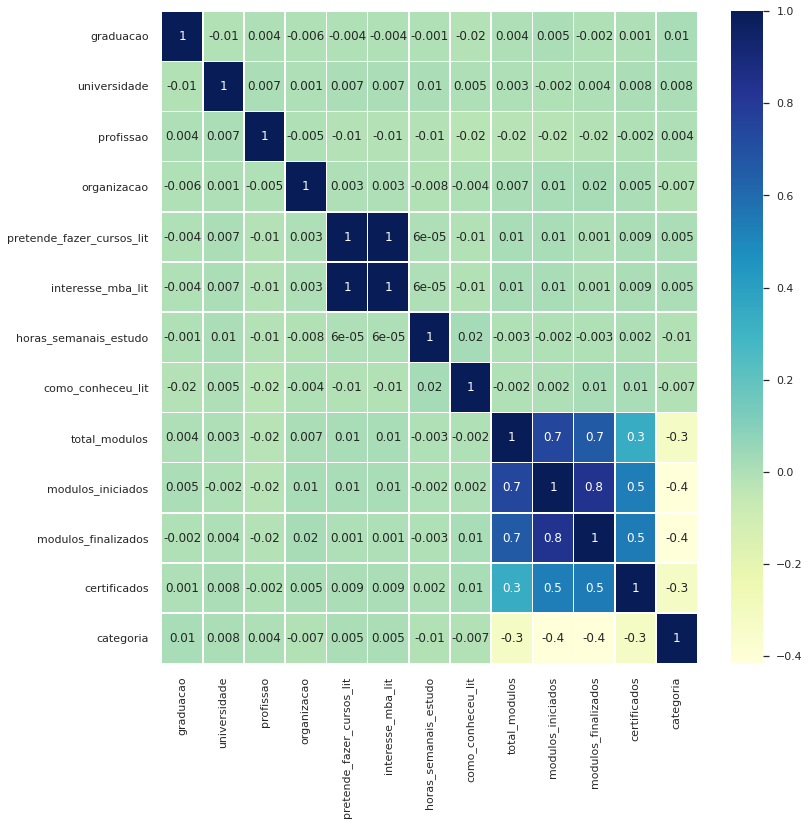

In [28]:
sns.set(rc={'figure.figsize':(12, 12)})
corr = dados.corr()
plt.figure() 
ax = sns.heatmap(corr, linewidths=.5, annot=True, cmap="YlGnBu", fmt='.1g')
plt.show()

# Parte 05. Feature Importance
> Nesta fase estarei verificando quais são as features de maior importancia para as previsoes do modelo

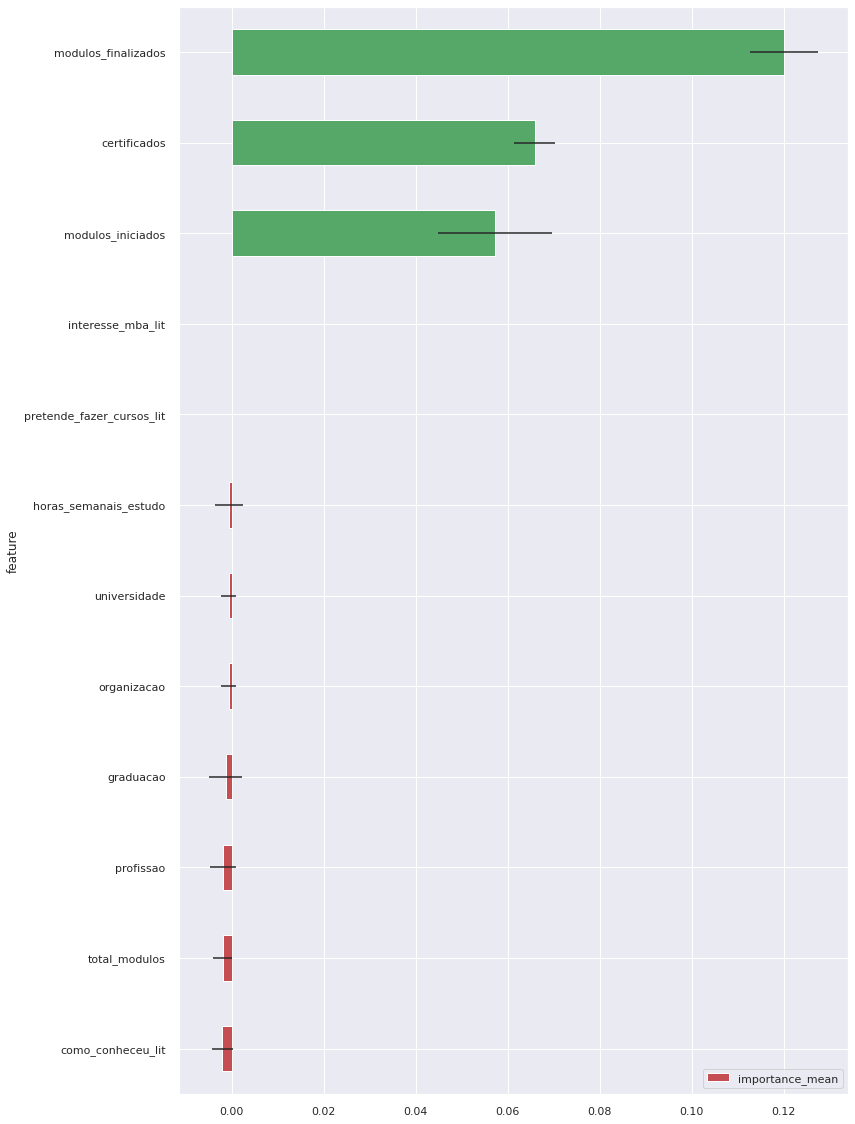

In [29]:
# define the validation scheme
cv = KFold(n_splits=5, shuffle=False, random_state=42)

# define the binary target and the features
dataset = Dataset(df=dados, target="categoria", features=[col for col in dados.columns if col != 'categoria'])

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="neg_mean_absolute_error")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

# Parte 06. Modelagem Preditiva
> Nesta fase estarei construindo os modelos preditivos
> Vou utilizar apenas o algoritmo Light GBM neste notebook

### LightGBM versão 01
> - Rodando a primeira versao com todas as features criadas
> - Usando train_test_split com 20% dos dados para testes
> - Sem aplicar nenhuma técnica de balanceamento

Acurácia : 79.8710271764164
Sensibilidade : 0.9500998003992016
Especificidade : 0.92


              precision    recall  f1-score   support

           0       0.82      0.79      0.80       349
           1       0.83      0.82      0.82       581
           2       0.66      0.65      0.66       124
           3       0.70      0.73      0.71       230
           4       0.81      0.77      0.79       267
           5       0.82      0.85      0.84       620

    accuracy                           0.80      2171
   macro avg       0.77      0.77      0.77      2171
weighted avg       0.80      0.80      0.80      2171



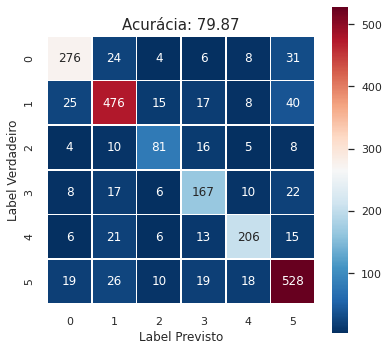

In [54]:
# Buscando todas as features do dataset apos o pre-processamento
all_features = [col for col in dados.columns if col != 'categoria']

# Separar target
X = dados[all_features]
y = dados['categoria']

# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter o dataset para o formato LGB
d_train = lgbm.Dataset(X_train, label=y_train)

# Especifica os parametros do modelo
params={}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective']     = 'multiclass'
params['num_class']     = 7
params['metric']        = 'multi_logloss'
params['max_depth']     = 10

# Especificando as features categoricas para o modelo
cat_features = ['graduacao','profissao','organizacao','como_conheceu_lit','universidade']

# Treinamento do modelo
modelo_lgb_v1 = lgbm.train(params, d_train, 2000, categorical_feature= cat_features)

# Previsões para cada classe com dados de teste
lgb_y_pred = modelo_lgb_v1.predict(X_test)

# Calcula o score com dados de teste
lgb_y_pred = [np.argmax(line) for line in lgb_y_pred]
lgb_score_v1 = accuracy_score(y_test, lgb_y_pred) * 100

# Print
print("Acurácia :", lgb_score_v1)

# Cria a matriz de confusão
conf_matriz_lgb = confusion_matrix(y_test, lgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_lgb = conf_matriz_lgb[0,0] / (conf_matriz_lgb[0,0] + conf_matriz_lgb[0,1])
sensi_lgb = conf_matriz_lgb[1,1] / (conf_matriz_lgb[1,0] + conf_matriz_lgb[1,1])

# Print
print('Sensibilidade :', sensi_lgb)
print('Especificidade :', speci_lgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_lgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(lgb_score_v1), size = 15)

# Relatório de Classificação
print(classification_report(y_test, lgb_y_pred))

### LightGBM versao 02
> - Rodando a segunda versao com apenas as melhores features identificadas no LOFO (media maior ou igual a zero)
> - Usando train_test_split com 20% dos dados para testes
> - Sem aplicar nenhuma técnica de balanceamento

Acurácia : 77.38369415016122
Sensibilidade : 0.9294605809128631
Especificidade : 0.8758620689655172


              precision    recall  f1-score   support

           0       0.78      0.73      0.75       349
           1       0.79      0.77      0.78       581
           2       0.66      0.65      0.66       124
           3       0.69      0.71      0.70       230
           4       0.80      0.76      0.78       267
           5       0.80      0.86      0.83       620

    accuracy                           0.77      2171
   macro avg       0.75      0.75      0.75      2171
weighted avg       0.77      0.77      0.77      2171



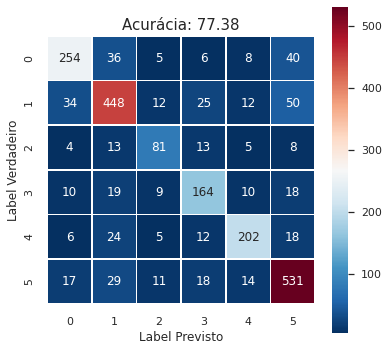

In [36]:
# Selecionando as melhoras features
features = importance_df[importance_df['importance_mean'] >= 0]['feature']

# Vamos armazenar 'PERFIL' no rótulo (y) e o restante das colunas em X
X = dados[features]
y = dados['categoria']

# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter o dataset para o formato LGB
d_train = lgbm.Dataset(X_train, label=y_train)

# Especifica os parametros do modelo
params={}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective']     = 'multiclass'
params['num_class']     = 7
params['metric']        = 'multi_logloss'
params['max_depth']     = 10

# Treinamento do modelo
modelo_lgb_v2 = lgbm.train(params, d_train, 2000, categorical_feature= "auto")

# Previsões para cada classe com dados de teste
lgb_y_pred = modelo_lgb_v2.predict(X_test)

# Calcula o score com dados de teste
lgb_y_pred = [np.argmax(line) for line in lgb_y_pred]
lgb_score_v2 = accuracy_score(y_test, lgb_y_pred) * 100

# Print
print("Acurácia :", lgb_score_v2)

# Cria a matriz de confusão
conf_matriz_lgb = confusion_matrix(y_test, lgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_lgb = conf_matriz_lgb[0,0] / (conf_matriz_lgb[0,0] + conf_matriz_lgb[0,1])
sensi_lgb = conf_matriz_lgb[1,1] / (conf_matriz_lgb[1,0] + conf_matriz_lgb[1,1])

# Print
print('Sensibilidade :', sensi_lgb)
print('Especificidade :', speci_lgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_lgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(lgb_score_v2), size = 15)

# Relatório de Classificação
print(classification_report(y_test, lgb_y_pred))

### LightGBM versão 03
> - Rodando a terceira versao com apenas as melhores features identificadas no LOFO (media maior ou igual a zero)
> - Usando train_test_split com 20% dos dados para testes
> - Aplicando o balanceamento SMOTE

Acurácia : 82.30208051877871
Sensibilidade : 0.9242144177449169
Especificidade : 0.9519408502772643


              precision    recall  f1-score   support

           0       0.83      0.81      0.82       637
           1       0.83      0.76      0.79       654
           2       0.87      0.87      0.87       613
           3       0.79      0.85      0.82       615
           4       0.85      0.82      0.84       547
           5       0.78      0.83      0.80       635

    accuracy                           0.82      3701
   macro avg       0.82      0.82      0.82      3701
weighted avg       0.82      0.82      0.82      3701



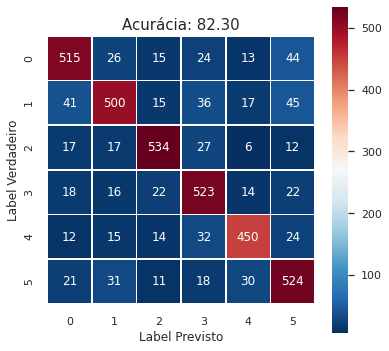

In [37]:
# Selecionando as melhoras features
features = importance_df[importance_df['importance_mean'] >= 0]['feature']

# Vamos armazenar 'PERFIL' no rótulo (y) e o restante das colunas em X
X = dados[features]
y = dados['categoria']

# Realizando o balanceamento dos dados para cada classe usando SMOTE
sm = SMOTE(random_state=0)
X, y = sm.fit_sample(X, y)

# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter o dataset para o formato LGB
d_train = lgbm.Dataset(X_train, label=y_train)

# Especifica os parametros do modelo
params={}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective']     = 'multiclass'
params['num_class']     = 7
params['metric']        = 'multi_logloss'
params['max_depth']     = 10

# Treinamento do modelo
modelo_lgb_v3 = lgbm.train(params, d_train, 2000, categorical_feature= "auto")

# Previsões para cada classe com dados de teste
lgb_y_pred = modelo_lgb_v3.predict(X_test)

# Calcula o score com dados de teste
lgb_y_pred = [np.argmax(line) for line in lgb_y_pred]
lgb_score_v3 = accuracy_score(y_test, lgb_y_pred) * 100

# Print
print("Acurácia :", lgb_score_v3)

# Cria a matriz de confusão
conf_matriz_lgb = confusion_matrix(y_test, lgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_lgb = conf_matriz_lgb[0,0] / (conf_matriz_lgb[0,0] + conf_matriz_lgb[0,1])
sensi_lgb = conf_matriz_lgb[1,1] / (conf_matriz_lgb[1,0] + conf_matriz_lgb[1,1])

# Print
print('Sensibilidade :', sensi_lgb)
print('Especificidade :', speci_lgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_lgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(lgb_score_v3), size = 15)

# Relatório de Classificação
print(classification_report(y_test, lgb_y_pred))

### LightGBM versão 04
> - Rodando a quarta versao com apenas as melhores features identificadas no LOFO (media maior ou igual a zero)
> - Usando train_test_split com 15% dos dados para testes
> - Aplicando o balanceamento SMOTE

Acurácia : 82.42074927953891
Sensibilidade : 0.9316455696202531
Especificidade : 0.9394673123486683


              precision    recall  f1-score   support

           0       0.83      0.80      0.82       483
           1       0.81      0.77      0.79       481
           2       0.88      0.88      0.88       469
           3       0.79      0.84      0.82       455
           4       0.85      0.83      0.84       410
           5       0.78      0.83      0.81       478

    accuracy                           0.82      2776
   macro avg       0.83      0.82      0.82      2776
weighted avg       0.83      0.82      0.82      2776



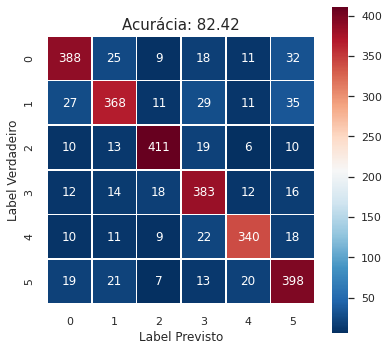

In [38]:
# Selecionando as melhoras features
features = importance_df[importance_df['importance_mean'] >= 0]['feature']

# Vamos armazenar 'PERFIL' no rótulo (y) e o restante das colunas em X
X = dados[features]
y = dados['categoria']

# Realizando o balanceamento dos dados para cada classe usando SMOTE
sm = SMOTE(random_state=0)
X, y = sm.fit_sample(X, y)

# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Converter o dataset para o formato LGB
d_train = lgbm.Dataset(X_train, label=y_train)

# Especifica os parametros do modelo
params={}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective']     = 'multiclass'
params['num_class']     = 7
params['metric']        = 'multi_logloss'
params['max_depth']     = 10

# Treinamento do modelo
modelo_lgb_v4 = lgbm.train(params, d_train, 2000, categorical_feature= "auto")

# Previsões para cada classe com dados de teste
lgb_y_pred = modelo_lgb_v4.predict(X_test)

# Calcula o score com dados de teste
lgb_y_pred = [np.argmax(line) for line in lgb_y_pred]
lgb_score_v4 = accuracy_score(y_test, lgb_y_pred) * 100

# Print
print("Acurácia :", lgb_score_v4)

# Cria a matriz de confusão
conf_matriz_lgb = confusion_matrix(y_test, lgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_lgb = conf_matriz_lgb[0,0] / (conf_matriz_lgb[0,0] + conf_matriz_lgb[0,1])
sensi_lgb = conf_matriz_lgb[1,1] / (conf_matriz_lgb[1,0] + conf_matriz_lgb[1,1])

# Print
print('Sensibilidade :', sensi_lgb)
print('Especificidade :', speci_lgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_lgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(lgb_score_v4), size = 15)

# Relatório de Classificação
print(classification_report(y_test, lgb_y_pred))

### LightGBM versão 05
> - Rodando a quinta versao com todas as features após as transformações e limpeza
> - Usando train_test_split com 15% dos dados para testes
> - Aplicando o balanceamento SMOTE

Acurácia : 85.73487031700289
Sensibilidade : 0.954653937947494
Especificidade : 0.9632183908045977


              precision    recall  f1-score   support

           0       0.84      0.87      0.86       483
           1       0.85      0.83      0.84       481
           2       0.91      0.88      0.90       469
           3       0.84      0.88      0.86       455
           4       0.87      0.85      0.86       410
           5       0.83      0.83      0.83       478

    accuracy                           0.86      2776
   macro avg       0.86      0.86      0.86      2776
weighted avg       0.86      0.86      0.86      2776



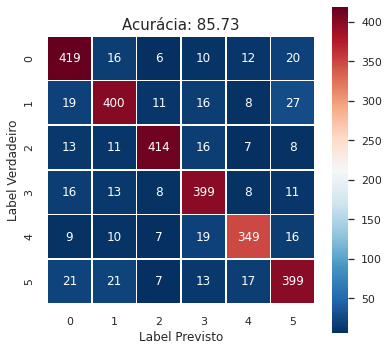

In [39]:
# Buscando todas as features do dataset apos o pre-processamento
all_features = [col for col in dados.columns if col != 'categoria']

# Separar target
X = dados[all_features]
y = dados['categoria']

# Realizando o balanceamento dos dados para cada classe usando SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_sample(X, y)

# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Converter o dataset para o formato LGB
d_train = lgbm.Dataset(X_train, label=y_train)

# Especifica os parametros do modelo
params={}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective']     = 'multiclass'
params['num_class']     = 7
params['metric']        = 'multi_logloss'
params['max_depth']     = 10

# Especificando as features categoricas para o modelo
cat_features = ['graduacao','profissao','organizacao','como_conheceu_lit','universidade']

# Treinamento do modelo
modelo_lgb_v5 = lgbm.train(params, d_train, 2000, categorical_feature=cat_features)

# Previsões para cada classe com dados de teste
lgb_y_pred = modelo_lgb_v5.predict(X_test)

# Calcula o score com dados de teste
lgb_y_pred = [np.argmax(line) for line in lgb_y_pred]
lgb_score_v5 = accuracy_score(y_test, lgb_y_pred) * 100

# Print
print("Acurácia :", lgb_score_v5)

# Cria a matriz de confusão
conf_matriz_lgb = confusion_matrix(y_test, lgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_lgb = conf_matriz_lgb[0,0] / (conf_matriz_lgb[0,0] + conf_matriz_lgb[0,1])
sensi_lgb = conf_matriz_lgb[1,1] / (conf_matriz_lgb[1,0] + conf_matriz_lgb[1,1])

# Print
print('Sensibilidade :', sensi_lgb)
print('Especificidade :', speci_lgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_lgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(lgb_score_v5), size = 15)

# Relatório de Classificação
print(classification_report(y_test, lgb_y_pred))

### LightGBM versão 06
> - Rodando a sexta versao com apenas as melhores features identificadas no LOFO (media maior ou igual a zero)
> - Usando train_test_split com 15% dos dados para testes
> - Aplicando o balanceamento SMOTE
> - Realizando a otimização dos hyperparametros com Optuna

tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.591772	valid_1's multi_logloss: 0.679799
[200]	training's multi_logloss: 0.525296	valid_1's multi_logloss: 0.670626
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.542927	valid_1's multi_logloss: 0.667764


tune_feature_fraction, val_score: 0.667764:  14%|#4        | 1/7 [00:03<00:17,  2.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.551595	valid_1's multi_logloss: 0.655927
[200]	training's multi_logloss: 0.493865	valid_1's multi_logloss: 0.652484
Early stopping, best iteration is:
[188]	training's multi_logloss: 0.49905	valid_1's multi_logloss: 0.651695


tune_feature_fraction, val_score: 0.651695:  29%|##8       | 2/7 [00:06<00:15,  3.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.551595	valid_1's multi_logloss: 0.655927
[200]	training's multi_logloss: 0.493865	valid_1's multi_logloss: 0.652484
Early stopping, best iteration is:
[188]	training's multi_logloss: 0.49905	valid_1's multi_logloss: 0.651695


tune_feature_fraction, val_score: 0.651695:  43%|####2     | 3/7 [00:10<00:13,  3.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.538691	valid_1's multi_logloss: 0.651217
[200]	training's multi_logloss: 0.478021	valid_1's multi_logloss: 0.647906
[300]	training's multi_logloss: 0.443108	valid_1's multi_logloss: 0.652874
Early stopping, best iteration is:
[210]	training's multi_logloss: 0.473948	valid_1's multi_logloss: 0.647293


tune_feature_fraction, val_score: 0.647293:  57%|#####7    | 4/7 [00:14<00:10,  3.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.538691	valid_1's multi_logloss: 0.651217
[200]	training's multi_logloss: 0.478021	valid_1's multi_logloss: 0.647906
[300]	training's multi_logloss: 0.443108	valid_1's multi_logloss: 0.652874
Early stopping, best iteration is:
[210]	training's multi_logloss: 0.473948	valid_1's multi_logloss: 0.647293


tune_feature_fraction, val_score: 0.647293:  71%|#######1  | 5/7 [00:18<00:07,  3.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.532694	valid_1's multi_logloss: 0.650709
[200]	training's multi_logloss: 0.471027	valid_1's multi_logloss: 0.64674
Early stopping, best iteration is:
[181]	training's multi_logloss: 0.479613	valid_1's multi_logloss: 0.646399


tune_feature_fraction, val_score: 0.646399:  86%|########5 | 6/7 [00:22<00:03,  3.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.532694	valid_1's multi_logloss: 0.650709
[200]	training's multi_logloss: 0.471027	valid_1's multi_logloss: 0.64674
Early stopping, best iteration is:
[181]	training's multi_logloss: 0.479613	valid_1's multi_logloss: 0.646399


tune_num_leaves, val_score: 0.646399:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.37077	valid_1's multi_logloss: 0.693677
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.464129	valid_1's multi_logloss: 0.651411


tune_num_leaves, val_score: 0.646399:   5%|5         | 1/20 [00:09<02:52,  9.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.369501	valid_1's multi_logloss: 0.696884
Early stopping, best iteration is:
[42]	training's multi_logloss: 0.481453	valid_1's multi_logloss: 0.652362


tune_num_leaves, val_score: 0.646399:  10%|#         | 2/20 [00:18<02:45,  9.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.606754	valid_1's multi_logloss: 0.66838
[200]	training's multi_logloss: 0.560007	valid_1's multi_logloss: 0.658062
[300]	training's multi_logloss: 0.528161	valid_1's multi_logloss: 0.65341
[400]	training's multi_logloss: 0.505616	valid_1's multi_logloss: 0.653607
Early stopping, best iteration is:
[315]	training's multi_logloss: 0.524862	valid_1's multi_logloss: 0.653021


tune_num_leaves, val_score: 0.646399:  15%|#5        | 3/20 [00:21<02:04,  7.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.364666	valid_1's multi_logloss: 0.704201
Early stopping, best iteration is:
[42]	training's multi_logloss: 0.476668	valid_1's multi_logloss: 0.652144


tune_num_leaves, val_score: 0.646399:  20%|##        | 4/20 [00:33<02:20,  8.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.367449	valid_1's multi_logloss: 0.697492
Early stopping, best iteration is:
[43]	training's multi_logloss: 0.475557	valid_1's multi_logloss: 0.651659


tune_num_leaves, val_score: 0.646399:  25%|##5       | 5/20 [00:44<02:17,  9.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.366978	valid_1's multi_logloss: 0.697047
Early stopping, best iteration is:
[42]	training's multi_logloss: 0.478899	valid_1's multi_logloss: 0.651517


tune_num_leaves, val_score: 0.646399:  30%|###       | 6/20 [00:54<02:12,  9.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.43595	valid_1's multi_logloss: 0.656337
Early stopping, best iteration is:
[68]	training's multi_logloss: 0.476541	valid_1's multi_logloss: 0.649045


tune_num_leaves, val_score: 0.646399:  35%|###5      | 7/20 [00:59<01:47,  8.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.468451	valid_1's multi_logloss: 0.649091
Early stopping, best iteration is:
[91]	training's multi_logloss: 0.477765	valid_1's multi_logloss: 0.648305


tune_num_leaves, val_score: 0.646399:  40%|####      | 8/20 [01:04<01:25,  7.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.508603	valid_1's multi_logloss: 0.649729
[200]	training's multi_logloss: 0.446462	valid_1's multi_logloss: 0.652322
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.475513	valid_1's multi_logloss: 0.649133


tune_num_leaves, val_score: 0.646399:  45%|####5     | 9/20 [01:08<01:08,  6.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.562133	valid_1's multi_logloss: 0.656974
[200]	training's multi_logloss: 0.502965	valid_1's multi_logloss: 0.652219
[300]	training's multi_logloss: 0.47032	valid_1's multi_logloss: 0.653717
Early stopping, best iteration is:
[218]	training's multi_logloss: 0.495291	valid_1's multi_logloss: 0.651334


tune_num_leaves, val_score: 0.646399:  50%|#####     | 10/20 [01:11<00:54,  5.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.393835	valid_1's multi_logloss: 0.671489
Early stopping, best iteration is:
[55]	training's multi_logloss: 0.463976	valid_1's multi_logloss: 0.648224


tune_num_leaves, val_score: 0.646399:  55%|#####5    | 11/20 [01:19<00:54,  6.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.392302	valid_1's multi_logloss: 0.676501
Early stopping, best iteration is:
[55]	training's multi_logloss: 0.461981	valid_1's multi_logloss: 0.649763


tune_num_leaves, val_score: 0.646399:  60%|######    | 12/20 [01:26<00:51,  6.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.393835	valid_1's multi_logloss: 0.671489
Early stopping, best iteration is:
[55]	training's multi_logloss: 0.463976	valid_1's multi_logloss: 0.648224


tune_num_leaves, val_score: 0.646399:  65%|######5   | 13/20 [01:34<00:47,  6.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.389439	valid_1's multi_logloss: 0.673916
Early stopping, best iteration is:
[50]	training's multi_logloss: 0.472406	valid_1's multi_logloss: 0.649713


tune_num_leaves, val_score: 0.646399:  70%|#######   | 14/20 [01:41<00:41,  6.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.414701	valid_1's multi_logloss: 0.661357
Early stopping, best iteration is:
[59]	training's multi_logloss: 0.47541	valid_1's multi_logloss: 0.648653


tune_num_leaves, val_score: 0.646399:  75%|#######5  | 15/20 [01:47<00:33,  6.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.38035	valid_1's multi_logloss: 0.6837
Early stopping, best iteration is:
[53]	training's multi_logloss: 0.456068	valid_1's multi_logloss: 0.650072


tune_num_leaves, val_score: 0.646399:  80%|########  | 16/20 [01:56<00:29,  7.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.409651	valid_1's multi_logloss: 0.663085
Early stopping, best iteration is:
[53]	training's multi_logloss: 0.484142	valid_1's multi_logloss: 0.648183


tune_num_leaves, val_score: 0.646399:  85%|########5 | 17/20 [02:02<00:20,  6.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.410575	valid_1's multi_logloss: 0.66211
Early stopping, best iteration is:
[55]	training's multi_logloss: 0.480503	valid_1's multi_logloss: 0.648047


tune_num_leaves, val_score: 0.646399:  90%|######### | 18/20 [02:08<00:13,  6.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.419424	valid_1's multi_logloss: 0.660034
Early stopping, best iteration is:
[58]	training's multi_logloss: 0.481772	valid_1's multi_logloss: 0.649607


tune_num_leaves, val_score: 0.646399:  95%|#########5| 19/20 [02:14<00:06,  6.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.462368	valid_1's multi_logloss: 0.652452
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.491773	valid_1's multi_logloss: 0.649436


tune_num_leaves, val_score: 0.646399: 100%|##########| 20/20 [02:18<00:00,  6.95s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.646399:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.529703	valid_1's multi_logloss: 0.655572
[200]	training's multi_logloss: 0.462522	valid_1's multi_logloss: 0.660358
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.506572	valid_1's multi_logloss: 0.653799


tune_bagging_fraction_and_bagging_freq, val_score: 0.646399:  10%|#         | 1/10 [00:02<00:25,  2.81s/it][I 2020-08-30 17:49:02,070] Finished trial#0 with value: 0.6537985803786893 with parameters: {'bagging_fraction': 0.6232866572593199, 'bagging_freq': 6}. Best is trial#0 with value: 0.6537985803786893.
tune_bagging_fraction_and_bagging_freq, val_score: 0.646399:  10%|#         | 1/10 [00:02<00:25,  2.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.528923	valid_1's multi_logloss: 0.652647
[200]	training's multi_logloss: 0.461569	valid_1's multi_logloss: 0.655871
Early stopping, best iteration is:
[117]	training's multi_logloss: 0.513379	valid_1's multi_logloss: 0.650683


tune_bagging_fraction_and_bagging_freq, val_score: 0.646399:  20%|##        | 2/10 [00:05<00:23,  2.88s/it][I 2020-08-30 17:49:05,115] Finished trial#1 with value: 0.6506826849851126 with parameters: {'bagging_fraction': 0.8663248178878611, 'bagging_freq': 7}. Best is trial#1 with value: 0.6506826849851126.
tune_bagging_fraction_and_bagging_freq, val_score: 0.646399:  20%|##        | 2/10 [00:06<00:23,  2.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.526218	valid_1's multi_logloss: 0.648905
[200]	training's multi_logloss: 0.46099	valid_1's multi_logloss: 0.647339
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.499207	valid_1's multi_logloss: 0.644738


tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  30%|###       | 3/10 [00:09<00:20,  2.99s/it][I 2020-08-30 17:49:08,345] Finished trial#2 with value: 0.6447376512847209 with parameters: {'bagging_fraction': 0.9476242838931347, 'bagging_freq': 3}. Best is trial#2 with value: 0.6447376512847209.
tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  30%|###       | 3/10 [00:09<00:20,  2.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.528111	valid_1's multi_logloss: 0.650608
[200]	training's multi_logloss: 0.463792	valid_1's multi_logloss: 0.648285
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.484874	valid_1's multi_logloss: 0.644876


tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  40%|####      | 4/10 [00:12<00:19,  3.18s/it][I 2020-08-30 17:49:12,000] Finished trial#3 with value: 0.6448760691169333 with parameters: {'bagging_fraction': 0.9678448673114457, 'bagging_freq': 7}. Best is trial#2 with value: 0.6447376512847209.
tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  40%|####      | 4/10 [00:12<00:19,  3.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.529607	valid_1's multi_logloss: 0.655459
[200]	training's multi_logloss: 0.460916	valid_1's multi_logloss: 0.655637
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.508974	valid_1's multi_logloss: 0.652008


tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  50%|#####     | 5/10 [00:15<00:15,  3.11s/it][I 2020-08-30 17:49:14,970] Finished trial#4 with value: 0.6520078041611234 with parameters: {'bagging_fraction': 0.7150053444948589, 'bagging_freq': 7}. Best is trial#2 with value: 0.6447376512847209.
tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  50%|#####     | 5/10 [00:15<00:15,  3.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.529161	valid_1's multi_logloss: 0.65938
[200]	training's multi_logloss: 0.461741	valid_1's multi_logloss: 0.655156
Early stopping, best iteration is:
[183]	training's multi_logloss: 0.470196	valid_1's multi_logloss: 0.654263


tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  60%|######    | 6/10 [00:19<00:13,  3.33s/it][I 2020-08-30 17:49:18,761] Finished trial#5 with value: 0.6542626938503241 with parameters: {'bagging_fraction': 0.5823277515384564, 'bagging_freq': 4}. Best is trial#2 with value: 0.6447376512847209.
tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  60%|######    | 6/10 [00:19<00:13,  3.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.529728	valid_1's multi_logloss: 0.654064
[200]	training's multi_logloss: 0.461823	valid_1's multi_logloss: 0.655341
Early stopping, best iteration is:
[132]	training's multi_logloss: 0.502458	valid_1's multi_logloss: 0.65245


tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  70%|#######   | 7/10 [00:22<00:09,  3.28s/it][I 2020-08-30 17:49:21,938] Finished trial#6 with value: 0.6524498528566206 with parameters: {'bagging_fraction': 0.6415085113909238, 'bagging_freq': 5}. Best is trial#2 with value: 0.6447376512847209.
tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  70%|#######   | 7/10 [00:22<00:09,  3.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.533166	valid_1's multi_logloss: 0.652916
[200]	training's multi_logloss: 0.463849	valid_1's multi_logloss: 0.654649
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.51286	valid_1's multi_logloss: 0.649453


tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  80%|########  | 8/10 [00:25<00:06,  3.19s/it][I 2020-08-30 17:49:24,907] Finished trial#7 with value: 0.6494534781126529 with parameters: {'bagging_fraction': 0.616690959104811, 'bagging_freq': 7}. Best is trial#2 with value: 0.6447376512847209.
tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  80%|########  | 8/10 [00:25<00:06,  3.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.530604	valid_1's multi_logloss: 0.649612
[200]	training's multi_logloss: 0.466112	valid_1's multi_logloss: 0.648114
Early stopping, best iteration is:
[152]	training's multi_logloss: 0.491448	valid_1's multi_logloss: 0.646496


tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  90%|######### | 9/10 [00:29<00:03,  3.28s/it][I 2020-08-30 17:49:28,392] Finished trial#8 with value: 0.6464964926695704 with parameters: {'bagging_fraction': 0.9883596284289276, 'bagging_freq': 5}. Best is trial#2 with value: 0.6447376512847209.
tune_bagging_fraction_and_bagging_freq, val_score: 0.644738:  90%|######### | 9/10 [00:29<00:03,  3.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.52793	valid_1's multi_logloss: 0.652356
[200]	training's multi_logloss: 0.461032	valid_1's multi_logloss: 0.654086
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.504517	valid_1's multi_logloss: 0.650104


tune_bagging_fraction_and_bagging_freq, val_score: 0.644738: 100%|##########| 10/10 [00:32<00:00,  3.25s/it][I 2020-08-30 17:49:31,580] Finished trial#9 with value: 0.650104406086611 with parameters: {'bagging_fraction': 0.8829328046685263, 'bagging_freq': 7}. Best is trial#2 with value: 0.6447376512847209.
tune_bagging_fraction_and_bagging_freq, val_score: 0.644738: 100%|##########| 10/10 [00:32<00:00,  3.25s/it]
tune_feature_fraction, val_score: 0.644738:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.534363	valid_1's multi_logloss: 0.648905
[200]	training's multi_logloss: 0.469179	valid_1's multi_logloss: 0.646505
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.491289	valid_1's multi_logloss: 0.645042


tune_feature_fraction, val_score: 0.644738:  17%|#6        | 1/6 [00:03<00:17,  3.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.534363	valid_1's multi_logloss: 0.648905
[200]	training's multi_logloss: 0.469179	valid_1's multi_logloss: 0.646505
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.491289	valid_1's multi_logloss: 0.645042


tune_feature_fraction, val_score: 0.644738:  33%|###3      | 2/6 [00:07<00:13,  3.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.534363	valid_1's multi_logloss: 0.648905
[200]	training's multi_logloss: 0.469179	valid_1's multi_logloss: 0.646505
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.491289	valid_1's multi_logloss: 0.645042


tune_feature_fraction, val_score: 0.644738:  50%|#####     | 3/6 [00:10<00:10,  3.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.526218	valid_1's multi_logloss: 0.648905
[200]	training's multi_logloss: 0.46099	valid_1's multi_logloss: 0.647339
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.499207	valid_1's multi_logloss: 0.644738


tune_feature_fraction, val_score: 0.644738:  67%|######6   | 4/6 [00:13<00:06,  3.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.526218	valid_1's multi_logloss: 0.648905
[200]	training's multi_logloss: 0.46099	valid_1's multi_logloss: 0.647339
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.499207	valid_1's multi_logloss: 0.644738


tune_feature_fraction, val_score: 0.644738:  83%|########3 | 5/6 [00:17<00:03,  3.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.526218	valid_1's multi_logloss: 0.648905
[200]	training's multi_logloss: 0.46099	valid_1's multi_logloss: 0.647339
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.499207	valid_1's multi_logloss: 0.644738


tune_feature_fraction, val_score: 0.644738: 100%|##########| 6/6 [00:20<00:00,  3.44s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.644738:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.526828	valid_1's multi_logloss: 0.649434
[200]	training's multi_logloss: 0.46113	valid_1's multi_logloss: 0.648892
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.499127	valid_1's multi_logloss: 0.646827


tune_lambda_l1_and_lambda_l2, val_score: 0.644738:   5%|5         | 1/20 [00:03<00:58,  3.06s/it][I 2020-08-30 17:49:55,535] Finished trial#0 with value: 0.6468272451944662 with parameters: {'lambda_l1': 0.0253631742017837, 'lambda_l2': 4.880780594515181e-06}. Best is trial#0 with value: 0.6468272451944662.
tune_lambda_l1_and_lambda_l2, val_score: 0.644738:   5%|5         | 1/20 [00:03<00:58,  3.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.526454	valid_1's multi_logloss: 0.649328
[200]	training's multi_logloss: 0.460477	valid_1's multi_logloss: 0.649353
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.482839	valid_1's multi_logloss: 0.646381


tune_lambda_l1_and_lambda_l2, val_score: 0.644738:  10%|#         | 2/20 [00:06<00:57,  3.19s/it][I 2020-08-30 17:49:59,015] Finished trial#1 with value: 0.6463811423214472 with parameters: {'lambda_l1': 0.00019091331034517712, 'lambda_l2': 0.00016052328866119936}. Best is trial#1 with value: 0.6463811423214472.
tune_lambda_l1_and_lambda_l2, val_score: 0.644738:  10%|#         | 2/20 [00:06<00:57,  3.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.530084	valid_1's multi_logloss: 0.647898
[200]	training's multi_logloss: 0.46544	valid_1's multi_logloss: 0.645628
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.502908	valid_1's multi_logloss: 0.644396


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  15%|#5        | 3/20 [00:09<00:54,  3.18s/it][I 2020-08-30 17:50:02,114] Finished trial#2 with value: 0.6443962386887526 with parameters: {'lambda_l1': 1.955465393709308e-08, 'lambda_l2': 0.2787749101478628}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  15%|#5        | 3/20 [00:09<00:54,  3.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.526285	valid_1's multi_logloss: 0.648879
[200]	training's multi_logloss: 0.460231	valid_1's multi_logloss: 0.648022
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.493945	valid_1's multi_logloss: 0.647187


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  20%|##        | 4/20 [00:12<00:50,  3.18s/it][I 2020-08-30 17:50:05,345] Finished trial#3 with value: 0.6471869506027081 with parameters: {'lambda_l1': 0.004651548432888379, 'lambda_l2': 5.80081013615272e-08}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  20%|##        | 4/20 [00:13<00:50,  3.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.534274	valid_1's multi_logloss: 0.649417
[200]	training's multi_logloss: 0.472302	valid_1's multi_logloss: 0.645483
[300]	training's multi_logloss: 0.435757	valid_1's multi_logloss: 0.650368
Early stopping, best iteration is:
[213]	training's multi_logloss: 0.46673	valid_1's multi_logloss: 0.645053


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  25%|##5       | 5/20 [00:17<00:52,  3.52s/it][I 2020-08-30 17:50:09,592] Finished trial#4 with value: 0.6450525280355915 with parameters: {'lambda_l1': 1.0487970738127096e-06, 'lambda_l2': 0.7870855201019091}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  25%|##5       | 5/20 [00:17<00:52,  3.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.525989	valid_1's multi_logloss: 0.64841
[200]	training's multi_logloss: 0.460029	valid_1's multi_logloss: 0.646818
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.499187	valid_1's multi_logloss: 0.645058


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  30%|###       | 6/20 [00:20<00:48,  3.49s/it][I 2020-08-30 17:50:13,020] Finished trial#5 with value: 0.6450583703638968 with parameters: {'lambda_l1': 0.0016769785663530632, 'lambda_l2': 1.0462331684329692e-06}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  30%|###       | 6/20 [00:20<00:48,  3.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.526218	valid_1's multi_logloss: 0.648905
[200]	training's multi_logloss: 0.46099	valid_1's multi_logloss: 0.647339
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.499207	valid_1's multi_logloss: 0.644738


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  35%|###5      | 7/20 [00:24<00:45,  3.46s/it][I 2020-08-30 17:50:16,415] Finished trial#6 with value: 0.6447376484286392 with parameters: {'lambda_l1': 9.973486220177154e-07, 'lambda_l2': 2.8503519142099178e-08}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  35%|###5      | 7/20 [00:24<00:45,  3.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.565577	valid_1's multi_logloss: 0.653917
[200]	training's multi_logloss: 0.521895	valid_1's multi_logloss: 0.646774
[300]	training's multi_logloss: 0.49967	valid_1's multi_logloss: 0.646222
[400]	training's multi_logloss: 0.486265	valid_1's multi_logloss: 0.645868
Early stopping, best iteration is:
[378]	training's multi_logloss: 0.488667	valid_1's multi_logloss: 0.645598


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  40%|####      | 8/20 [00:30<00:52,  4.36s/it][I 2020-08-30 17:50:22,875] Finished trial#7 with value: 0.6455979445182115 with parameters: {'lambda_l1': 2.132257544359482, 'lambda_l2': 2.067678560747496e-07}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  40%|####      | 8/20 [00:30<00:52,  4.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.525877	valid_1's multi_logloss: 0.648549
[200]	training's multi_logloss: 0.460769	valid_1's multi_logloss: 0.647772
Early stopping, best iteration is:
[142]	training's multi_logloss: 0.493704	valid_1's multi_logloss: 0.645544


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  45%|####5     | 9/20 [00:33<00:44,  4.05s/it][I 2020-08-30 17:50:26,277] Finished trial#8 with value: 0.6455441026930472 with parameters: {'lambda_l1': 0.0002220351788178433, 'lambda_l2': 0.011643515736643014}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  45%|####5     | 9/20 [00:34<00:44,  4.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.526218	valid_1's multi_logloss: 0.648905
[200]	training's multi_logloss: 0.46099	valid_1's multi_logloss: 0.647339
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.499207	valid_1's multi_logloss: 0.644738


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  50%|#####     | 10/20 [00:36<00:37,  3.76s/it][I 2020-08-30 17:50:29,288] Finished trial#9 with value: 0.6447376507251921 with parameters: {'lambda_l1': 1.8444220340657518e-07, 'lambda_l2': 2.821937775587269e-08}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  50%|#####     | 10/20 [00:37<00:37,  3.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.557911	valid_1's multi_logloss: 0.653538
[200]	training's multi_logloss: 0.50278	valid_1's multi_logloss: 0.646076
[300]	training's multi_logloss: 0.469662	valid_1's multi_logloss: 0.645105
Early stopping, best iteration is:
[235]	training's multi_logloss: 0.489886	valid_1's multi_logloss: 0.644466


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  55%|#####5    | 11/20 [00:41<00:35,  3.99s/it][I 2020-08-30 17:50:33,816] Finished trial#10 with value: 0.6444662139234785 with parameters: {'lambda_l1': 2.2501917867883813e-08, 'lambda_l2': 5.047288647968355}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  55%|#####5    | 11/20 [00:41<00:35,  3.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.572129	valid_1's multi_logloss: 0.656242
[200]	training's multi_logloss: 0.519966	valid_1's multi_logloss: 0.648029
[300]	training's multi_logloss: 0.488606	valid_1's multi_logloss: 0.645399
[400]	training's multi_logloss: 0.466102	valid_1's multi_logloss: 0.646151
Early stopping, best iteration is:
[307]	training's multi_logloss: 0.486889	valid_1's multi_logloss: 0.644852


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  60%|######    | 12/20 [00:46<00:35,  4.45s/it][I 2020-08-30 17:50:39,321] Finished trial#11 with value: 0.6448524949839711 with parameters: {'lambda_l1': 1.3264386879691506e-08, 'lambda_l2': 9.9633948714313}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  60%|######    | 12/20 [00:47<00:35,  4.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.527378	valid_1's multi_logloss: 0.649303
[200]	training's multi_logloss: 0.462663	valid_1's multi_logloss: 0.649452
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.501226	valid_1's multi_logloss: 0.646735


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  65%|######5   | 13/20 [00:50<00:28,  4.07s/it][I 2020-08-30 17:50:42,530] Finished trial#12 with value: 0.6467354692267135 with parameters: {'lambda_l1': 1.1862639934710945e-08, 'lambda_l2': 0.10581170392772901}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  65%|######5   | 13/20 [00:50<00:28,  4.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.567237	valid_1's multi_logloss: 0.655064
[200]	training's multi_logloss: 0.513536	valid_1's multi_logloss: 0.646674
[300]	training's multi_logloss: 0.481406	valid_1's multi_logloss: 0.645044
Early stopping, best iteration is:
[281]	training's multi_logloss: 0.486687	valid_1's multi_logloss: 0.644519


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  70%|#######   | 14/20 [00:55<00:26,  4.43s/it][I 2020-08-30 17:50:47,845] Finished trial#13 with value: 0.6445191236037711 with parameters: {'lambda_l1': 1.0939460803856157e-07, 'lambda_l2': 7.812235394643268}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  70%|#######   | 14/20 [00:55<00:26,  4.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.527242	valid_1's multi_logloss: 0.647683
[200]	training's multi_logloss: 0.460765	valid_1's multi_logloss: 0.648126
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.500651	valid_1's multi_logloss: 0.645865


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  75%|#######5  | 15/20 [00:58<00:20,  4.13s/it][I 2020-08-30 17:50:51,300] Finished trial#14 with value: 0.6458654923293863 with parameters: {'lambda_l1': 9.193016451875125e-06, 'lambda_l2': 0.005251430712557004}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  75%|#######5  | 15/20 [00:59<00:20,  4.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.532799	valid_1's multi_logloss: 0.648624
[200]	training's multi_logloss: 0.46967	valid_1's multi_logloss: 0.646315
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.505999	valid_1's multi_logloss: 0.645005


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  80%|########  | 16/20 [01:02<00:15,  3.90s/it][I 2020-08-30 17:50:54,646] Finished trial#15 with value: 0.645005012389645 with parameters: {'lambda_l1': 1.6286033713326512e-08, 'lambda_l2': 0.5745196727340219}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  80%|########  | 16/20 [01:02<00:15,  3.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.526136	valid_1's multi_logloss: 0.650632
[200]	training's multi_logloss: 0.46023	valid_1's multi_logloss: 0.64764
Early stopping, best iteration is:
[180]	training's multi_logloss: 0.471012	valid_1's multi_logloss: 0.64634


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  85%|########5 | 17/20 [01:06<00:11,  3.88s/it][I 2020-08-30 17:50:58,497] Finished trial#16 with value: 0.6463404447894091 with parameters: {'lambda_l1': 1.3313957542814475e-05, 'lambda_l2': 0.0005410182930107744}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  85%|########5 | 17/20 [01:06<00:11,  3.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.647131	valid_1's multi_logloss: 0.680357
[200]	training's multi_logloss: 0.634712	valid_1's multi_logloss: 0.674308
[300]	training's multi_logloss: 0.630162	valid_1's multi_logloss: 0.672351
[400]	training's multi_logloss: 0.627302	valid_1's multi_logloss: 0.671051
[500]	training's multi_logloss: 0.624944	valid_1's multi_logloss: 0.670077
[600]	training's multi_logloss: 0.622832	valid_1's multi_logloss: 0.669545
[700]	training's multi_logloss: 0.621285	valid_1's multi_logloss: 0.669051
[800]	training's multi_logloss: 0.620061	valid_1's multi_logloss: 0.668715
[900]	training's multi_logloss: 0.618734	valid_1's multi_logloss: 0.668239
[1000]	training's multi_logloss: 0.617383	valid_1's multi_logloss: 0.667822
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.617383	valid_1's multi_logloss: 0.667822


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  90%|######### | 18/20 [01:11<00:08,  4.39s/it][I 2020-08-30 17:51:03,994] Finished trial#17 with value: 0.6678216493477972 with parameters: {'lambda_l1': 9.731188416170452, 'lambda_l2': 1.640906042628836}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  90%|######### | 18/20 [01:11<00:08,  4.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.526922	valid_1's multi_logloss: 0.648253
[200]	training's multi_logloss: 0.461482	valid_1's multi_logloss: 0.648506
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.499586	valid_1's multi_logloss: 0.646422


tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  95%|#########5| 19/20 [01:15<00:04,  4.10s/it][I 2020-08-30 17:51:07,403] Finished trial#18 with value: 0.6464218734930408 with parameters: {'lambda_l1': 1.2712463575771925e-07, 'lambda_l2': 0.04901760764015551}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396:  95%|#########5| 19/20 [01:15<00:04,  4.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.573647	valid_1's multi_logloss: 0.657916
[200]	training's multi_logloss: 0.522095	valid_1's multi_logloss: 0.650199
[300]	training's multi_logloss: 0.491839	valid_1's multi_logloss: 0.647232
[400]	training's multi_logloss: 0.469907	valid_1's multi_logloss: 0.647018
Early stopping, best iteration is:
[348]	training's multi_logloss: 0.480387	valid_1's multi_logloss: 0.646695


tune_lambda_l1_and_lambda_l2, val_score: 0.644396: 100%|##########| 20/20 [01:21<00:00,  4.73s/it][I 2020-08-30 17:51:13,651] Finished trial#19 with value: 0.6466946915002999 with parameters: {'lambda_l1': 0.27586307878143257, 'lambda_l2': 9.40404631296114}. Best is trial#2 with value: 0.6443962386887526.
tune_lambda_l1_and_lambda_l2, val_score: 0.644396: 100%|##########| 20/20 [01:21<00:00,  4.07s/it]
tune_min_child_samples, val_score: 0.644396:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.510414	valid_1's multi_logloss: 0.64093
[200]	training's multi_logloss: 0.443622	valid_1's multi_logloss: 0.638238
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.456293	valid_1's multi_logloss: 0.637047


tune_min_child_samples, val_score: 0.637047:  20%|##        | 1/5 [00:03<00:14,  3.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.517287	valid_1's multi_logloss: 0.643829
[200]	training's multi_logloss: 0.45087	valid_1's multi_logloss: 0.642109
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.462888	valid_1's multi_logloss: 0.64103


tune_min_child_samples, val_score: 0.637047:  40%|####      | 2/5 [00:07<00:11,  3.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.534743	valid_1's multi_logloss: 0.64964
[200]	training's multi_logloss: 0.471003	valid_1's multi_logloss: 0.648235
Early stopping, best iteration is:
[136]	training's multi_logloss: 0.507169	valid_1's multi_logloss: 0.646834


tune_min_child_samples, val_score: 0.637047:  60%|######    | 3/5 [00:10<00:07,  3.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.550214	valid_1's multi_logloss: 0.65512
[200]	training's multi_logloss: 0.489502	valid_1's multi_logloss: 0.6527
[300]	training's multi_logloss: 0.452742	valid_1's multi_logloss: 0.654712
Early stopping, best iteration is:
[223]	training's multi_logloss: 0.479772	valid_1's multi_logloss: 0.652154


tune_min_child_samples, val_score: 0.637047:  80%|########  | 4/5 [00:15<00:03,  3.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.562898	valid_1's multi_logloss: 0.66147
[200]	training's multi_logloss: 0.505778	valid_1's multi_logloss: 0.655292
[300]	training's multi_logloss: 0.471077	valid_1's multi_logloss: 0.655896
Early stopping, best iteration is:
[227]	training's multi_logloss: 0.495237	valid_1's multi_logloss: 0.653947


tune_min_child_samples, val_score: 0.637047: 100%|##########| 5/5 [00:19<00:00,  3.96s/it]


Acurácia : 81.23198847262248
Sensibilidade : 0.8852459016393442
Especificidade : 0.9602803738317757


              precision    recall  f1-score   support

           0       0.66      0.85      0.75       483
           1       0.86      0.79      0.82       481
           2       0.90      0.83      0.87       469
           3       0.87      0.76      0.81       455
           4       0.86      0.81      0.83       410
           5       0.80      0.83      0.82       478

    accuracy                           0.81      2776
   macro avg       0.83      0.81      0.82      2776
weighted avg       0.82      0.81      0.81      2776

Best params: {'objective': 'multiclass', 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_class': 7, 'lambda_l1': 1.955465393709308e-08, 'lambda_l2': 0.2787749101478628, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.9476242838931347, 'bagging_freq': 3, 'min_child_samples': 5}
  Params: 
    obje

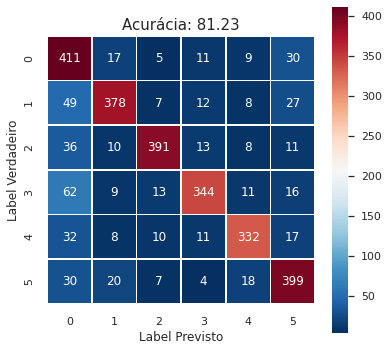

In [40]:
# Selecionando as melhoras features
features = importance_df[importance_df['importance_mean'] >= 0]['feature']

# Vamos armazenar 'PERFIL' no rótulo (y) e o restante das colunas em X
X = dados[features]
y = dados['categoria']

# Realizando o balanceamento dos dados para cada classe usando SMOTE
sm = SMOTE(random_state=0)
X, y = sm.fit_sample(X, y)

# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Preparando o dataset para o modelo
train_data = lgb2.Dataset(X_train, label=y_train, categorical_feature='auto', free_raw_data=False)
val_data   = lgb2.Dataset(X_test, label=y_test, categorical_feature='auto', free_raw_data=False)

lgb_params = {
    "objective"    : "multiclass",
    "metric"       : "multi_logloss",
    "verbosity"    : -1,
    "boosting_type": "gbdt",
    'num_class'    : 7
}

# Realizando o treinamento do modelo LGBM
modelo_lgb_v6 = lgb2.train(lgb_params, 
                           train_data, 
                           valid_sets=[train_data,val_data],
                           verbose_eval=100, 
                           early_stopping_rounds=100,)

# Previsões para cada classe com dados de teste
lgb_y_pred = np.rint(modelo_lgb_v6.predict(X_test, num_iteration=modelo_lgb_v6.best_iteration))

# Calcula o score com dados de teste
lgb_y_pred = [np.argmax(line) for line in lgb_y_pred]
lgb_score_v6 = accuracy_score(y_test, lgb_y_pred) * 100

# Print
print("Acurácia :", lgb_score_v6)

# Cria a matriz de confusão
conf_matriz_lgb = confusion_matrix(y_test, lgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_lgb = conf_matriz_lgb[0,0] / (conf_matriz_lgb[0,0] + conf_matriz_lgb[0,1])
sensi_lgb = conf_matriz_lgb[1,1] / (conf_matriz_lgb[1,0] + conf_matriz_lgb[1,1])

# Print
print('Sensibilidade :', sensi_lgb)
print('Especificidade :', speci_lgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_lgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(lgb_score_v6), size = 15)

# Relatório de Classificação
print(classification_report(y_test, lgb_y_pred))

# Exibindo os melhores parametros e desempenho do modelo
best_params = modelo_lgb_v6.params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

### LightGBM versão 07
> - Rodando a setima versao com todas as features criadas e apos a limpeza
> - Usando train_test_split com 15% dos dados para testes
> - Aplicando o balanceamento SMOTE
> - Realizando a otimização dos hyperparametros com Optuna

tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.422716	valid_1's multi_logloss: 0.616945
[200]	training's multi_logloss: 0.267959	valid_1's multi_logloss: 0.596163
[300]	training's multi_logloss: 0.177364	valid_1's multi_logloss: 0.594628
Early stopping, best iteration is:
[254]	training's multi_logloss: 0.214119	valid_1's multi_logloss: 0.59352


tune_feature_fraction, val_score: 0.593520:  14%|#4        | 1/7 [00:04<00:25,  4.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.401654	valid_1's multi_logloss: 0.613099
[200]	training's multi_logloss: 0.246926	valid_1's multi_logloss: 0.594309
[300]	training's multi_logloss: 0.160404	valid_1's multi_logloss: 0.594912
Early stopping, best iteration is:
[260]	training's multi_logloss: 0.188555	valid_1's multi_logloss: 0.5911


tune_feature_fraction, val_score: 0.591100:  29%|##8       | 2/7 [00:09<00:21,  4.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.381093	valid_1's multi_logloss: 0.609209
[200]	training's multi_logloss: 0.225814	valid_1's multi_logloss: 0.592105
[300]	training's multi_logloss: 0.141251	valid_1's multi_logloss: 0.592114
Early stopping, best iteration is:
[256]	training's multi_logloss: 0.173873	valid_1's multi_logloss: 0.588983


tune_feature_fraction, val_score: 0.588983:  43%|####2     | 3/7 [00:13<00:17,  4.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.365053	valid_1's multi_logloss: 0.60708
[200]	training's multi_logloss: 0.21203	valid_1's multi_logloss: 0.586788
[300]	training's multi_logloss: 0.128329	valid_1's multi_logloss: 0.588181
Early stopping, best iteration is:
[237]	training's multi_logloss: 0.176652	valid_1's multi_logloss: 0.584853


tune_feature_fraction, val_score: 0.584853:  57%|#####7    | 4/7 [00:18<00:13,  4.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.346298	valid_1's multi_logloss: 0.602568
[200]	training's multi_logloss: 0.19426	valid_1's multi_logloss: 0.589058
Early stopping, best iteration is:
[197]	training's multi_logloss: 0.197261	valid_1's multi_logloss: 0.588767


tune_feature_fraction, val_score: 0.584853:  71%|#######1  | 5/7 [00:22<00:08,  4.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.339485	valid_1's multi_logloss: 0.604291
[200]	training's multi_logloss: 0.187695	valid_1's multi_logloss: 0.594685
Early stopping, best iteration is:
[194]	training's multi_logloss: 0.194058	valid_1's multi_logloss: 0.594251


tune_feature_fraction, val_score: 0.584853:  86%|########5 | 6/7 [00:26<00:04,  4.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.334601	valid_1's multi_logloss: 0.608693
[200]	training's multi_logloss: 0.182866	valid_1's multi_logloss: 0.596796
Early stopping, best iteration is:
[188]	training's multi_logloss: 0.195664	valid_1's multi_logloss: 0.595742


tune_num_leaves, val_score: 0.584853:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.137959	valid_1's multi_logloss: 0.580209
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.170124	valid_1's multi_logloss: 0.578704


tune_num_leaves, val_score: 0.578704:   5%|5         | 1/20 [00:07<02:26,  7.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0463754	valid_1's multi_logloss: 0.60233
Early stopping, best iteration is:
[61]	training's multi_logloss: 0.154967	valid_1's multi_logloss: 0.573351


tune_num_leaves, val_score: 0.573351:  10%|#         | 2/20 [00:19<02:36,  8.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0675629	valid_1's multi_logloss: 0.593129
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.1617	valid_1's multi_logloss: 0.577817


tune_num_leaves, val_score: 0.573351:  15%|#5        | 3/20 [00:28<02:29,  8.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.18043	valid_1's multi_logloss: 0.580894
[200]	training's multi_logloss: 0.0531854	valid_1's multi_logloss: 0.610727
Early stopping, best iteration is:
[105]	training's multi_logloss: 0.168917	valid_1's multi_logloss: 0.580561


tune_num_leaves, val_score: 0.573351:  20%|##        | 4/20 [00:33<02:05,  7.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.199662	valid_1's multi_logloss: 0.581393
[200]	training's multi_logloss: 0.0653267	valid_1's multi_logloss: 0.603228
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.173943	valid_1's multi_logloss: 0.580769


tune_num_leaves, val_score: 0.573351:  25%|##5       | 5/20 [00:38<01:45,  7.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0579677	valid_1's multi_logloss: 0.591206
Early stopping, best iteration is:
[69]	training's multi_logloss: 0.138871	valid_1's multi_logloss: 0.572039


tune_num_leaves, val_score: 0.572039:  30%|###       | 6/20 [00:48<01:51,  7.94s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0470533	valid_1's multi_logloss: 0.598342
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.129099	valid_1's multi_logloss: 0.571115


tune_num_leaves, val_score: 0.571115:  35%|###5      | 7/20 [00:59<01:56,  8.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.142071	valid_1's multi_logloss: 0.579984
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.159758	valid_1's multi_logloss: 0.578246


tune_num_leaves, val_score: 0.571115:  40%|####      | 8/20 [01:06<01:37,  8.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.11746	valid_1's multi_logloss: 0.578559
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.151326	valid_1's multi_logloss: 0.575881


tune_num_leaves, val_score: 0.571115:  45%|####5     | 9/20 [01:12<01:24,  7.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0686291	valid_1's multi_logloss: 0.589804
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.142874	valid_1's multi_logloss: 0.575706


tune_num_leaves, val_score: 0.571115:  50%|#####     | 10/20 [01:21<01:20,  8.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.384788	valid_1's multi_logloss: 0.610298
[200]	training's multi_logloss: 0.235504	valid_1's multi_logloss: 0.590034
[300]	training's multi_logloss: 0.150067	valid_1's multi_logloss: 0.587453
Early stopping, best iteration is:
[265]	training's multi_logloss: 0.174759	valid_1's multi_logloss: 0.585813


tune_num_leaves, val_score: 0.571115:  55%|#####5    | 11/20 [01:26<01:02,  6.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0462996	valid_1's multi_logloss: 0.604594
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.127399	valid_1's multi_logloss: 0.575312


tune_num_leaves, val_score: 0.571115:  60%|######    | 12/20 [01:37<01:05,  8.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0624522	valid_1's multi_logloss: 0.594001
Early stopping, best iteration is:
[68]	training's multi_logloss: 0.149655	valid_1's multi_logloss: 0.575757


tune_num_leaves, val_score: 0.571115:  65%|######5   | 13/20 [01:46<00:59,  8.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0548033	valid_1's multi_logloss: 0.594547
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.142037	valid_1's multi_logloss: 0.573215


tune_num_leaves, val_score: 0.571115:  70%|#######   | 14/20 [01:57<00:55,  9.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0863382	valid_1's multi_logloss: 0.581771
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.158599	valid_1's multi_logloss: 0.573515


tune_num_leaves, val_score: 0.571115:  75%|#######5  | 15/20 [02:05<00:44,  8.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.052353	valid_1's multi_logloss: 0.597943
Early stopping, best iteration is:
[61]	training's multi_logloss: 0.16533	valid_1's multi_logloss: 0.574401


tune_num_leaves, val_score: 0.571115:  80%|########  | 16/20 [02:15<00:36,  9.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0850842	valid_1's multi_logloss: 0.583381
Early stopping, best iteration is:
[75]	training's multi_logloss: 0.152794	valid_1's multi_logloss: 0.57269


tune_num_leaves, val_score: 0.571115:  85%|########5 | 17/20 [02:23<00:26,  8.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0525536	valid_1's multi_logloss: 0.597591
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.1379	valid_1's multi_logloss: 0.575899


tune_num_leaves, val_score: 0.571115:  90%|######### | 18/20 [02:34<00:19,  9.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0836498	valid_1's multi_logloss: 0.58357
Early stopping, best iteration is:
[71]	training's multi_logloss: 0.166765	valid_1's multi_logloss: 0.57582


tune_num_leaves, val_score: 0.571115:  95%|#########5| 19/20 [02:42<00:09,  9.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0469814	valid_1's multi_logloss: 0.603754
Early stopping, best iteration is:
[61]	training's multi_logloss: 0.155585	valid_1's multi_logloss: 0.571918


tune_num_leaves, val_score: 0.571115: 100%|##########| 20/20 [02:54<00:00,  8.72s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.082613	valid_1's multi_logloss: 0.59027
Early stopping, best iteration is:
[71]	training's multi_logloss: 0.170126	valid_1's multi_logloss: 0.577933


tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  10%|#         | 1/10 [00:10<01:36, 10.72s/it][I 2020-08-30 17:55:10,278] Finished trial#0 with value: 0.5779326955570766 with parameters: {'bagging_fraction': 0.6226335436961135, 'bagging_freq': 2}. Best is trial#0 with value: 0.5779326955570766.
tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  10%|#         | 1/10 [00:10<01:36, 10.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.139604	valid_1's multi_logloss: 0.595543
Early stopping, best iteration is:
[79]	training's multi_logloss: 0.208125	valid_1's multi_logloss: 0.590815


tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  20%|##        | 2/10 [00:20<01:24, 10.58s/it][I 2020-08-30 17:55:20,545] Finished trial#1 with value: 0.5908150107525977 with parameters: {'bagging_fraction': 0.4417759004431175, 'bagging_freq': 2}. Best is trial#0 with value: 0.5779326955570766.
tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  20%|##        | 2/10 [00:21<01:24, 10.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0795757	valid_1's multi_logloss: 0.588626
Early stopping, best iteration is:
[68]	training's multi_logloss: 0.177637	valid_1's multi_logloss: 0.575422


tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  30%|###       | 3/10 [00:31<01:14, 10.63s/it][I 2020-08-30 17:55:31,216] Finished trial#2 with value: 0.5754219972042682 with parameters: {'bagging_fraction': 0.6666068971241951, 'bagging_freq': 6}. Best is trial#2 with value: 0.5754219972042682.
tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  30%|###       | 3/10 [00:31<01:14, 10.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0531923	valid_1's multi_logloss: 0.596353
Early stopping, best iteration is:
[68]	training's multi_logloss: 0.136033	valid_1's multi_logloss: 0.573263


tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  40%|####      | 4/10 [00:43<01:05, 10.84s/it][I 2020-08-30 17:55:42,548] Finished trial#3 with value: 0.5732629776108639 with parameters: {'bagging_fraction': 0.8912560165421166, 'bagging_freq': 5}. Best is trial#3 with value: 0.5732629776108639.
tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  40%|####      | 4/10 [00:43<01:05, 10.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.152184	valid_1's multi_logloss: 0.599459
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.199003	valid_1's multi_logloss: 0.592243


tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  50%|#####     | 5/10 [00:53<00:53, 10.77s/it][I 2020-08-30 17:55:53,237] Finished trial#4 with value: 0.5922430695396042 with parameters: {'bagging_fraction': 0.44064398666185983, 'bagging_freq': 7}. Best is trial#3 with value: 0.5732629776108639.
tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  50%|#####     | 5/10 [00:53<00:53, 10.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0579847	valid_1's multi_logloss: 0.59783
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.129044	valid_1's multi_logloss: 0.580026


tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  60%|######    | 6/10 [01:05<00:44, 11.05s/it][I 2020-08-30 17:56:04,899] Finished trial#5 with value: 0.5800259323294218 with parameters: {'bagging_fraction': 0.8376525268919022, 'bagging_freq': 6}. Best is trial#3 with value: 0.5732629776108639.
tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  60%|######    | 6/10 [01:05<00:44, 11.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.105283	valid_1's multi_logloss: 0.597936
Early stopping, best iteration is:
[75]	training's multi_logloss: 0.183363	valid_1's multi_logloss: 0.586675


tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  70%|#######   | 7/10 [01:16<00:32, 10.99s/it][I 2020-08-30 17:56:15,791] Finished trial#6 with value: 0.5866751232367299 with parameters: {'bagging_fraction': 0.556483860247483, 'bagging_freq': 6}. Best is trial#3 with value: 0.5732629776108639.
tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  70%|#######   | 7/10 [01:16<00:32, 10.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.053518	valid_1's multi_logloss: 0.595876
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.150575	valid_1's multi_logloss: 0.574236


tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  80%|########  | 8/10 [01:28<00:22, 11.24s/it][I 2020-08-30 17:56:27,589] Finished trial#7 with value: 0.5742358449206398 with parameters: {'bagging_fraction': 0.8814496807934107, 'bagging_freq': 4}. Best is trial#3 with value: 0.5732629776108639.
tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  80%|########  | 8/10 [01:28<00:22, 11.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0829617	valid_1's multi_logloss: 0.597736
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.164289	valid_1's multi_logloss: 0.57956


tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  90%|######### | 9/10 [01:40<00:11, 11.61s/it][I 2020-08-30 17:56:40,009] Finished trial#8 with value: 0.5795597387305413 with parameters: {'bagging_fraction': 0.6498814304174568, 'bagging_freq': 5}. Best is trial#3 with value: 0.5732629776108639.
tune_bagging_fraction_and_bagging_freq, val_score: 0.571115:  90%|######### | 9/10 [01:40<00:11, 11.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.136845	valid_1's multi_logloss: 0.599427
Early stopping, best iteration is:
[81]	training's multi_logloss: 0.196027	valid_1's multi_logloss: 0.591778


tune_bagging_fraction_and_bagging_freq, val_score: 0.571115: 100%|##########| 10/10 [01:51<00:00, 11.38s/it][I 2020-08-30 17:56:50,856] Finished trial#9 with value: 0.5917775124630033 with parameters: {'bagging_fraction': 0.46383745464794, 'bagging_freq': 4}. Best is trial#3 with value: 0.5732629776108639.
tune_bagging_fraction_and_bagging_freq, val_score: 0.571115: 100%|##########| 10/10 [01:51<00:00, 11.15s/it]
tune_feature_fraction, val_score: 0.571115:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0614573	valid_1's multi_logloss: 0.590712
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.121134	valid_1's multi_logloss: 0.577237


tune_feature_fraction, val_score: 0.571115:  17%|#6        | 1/6 [00:12<01:02, 12.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0470533	valid_1's multi_logloss: 0.598342
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.129099	valid_1's multi_logloss: 0.571115


tune_feature_fraction, val_score: 0.571115:  33%|###3      | 2/6 [00:26<00:51, 12.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0470533	valid_1's multi_logloss: 0.598342
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.129099	valid_1's multi_logloss: 0.571115


tune_feature_fraction, val_score: 0.571115:  50%|#####     | 3/6 [00:38<00:37, 12.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0382067	valid_1's multi_logloss: 0.61366
Early stopping, best iteration is:
[59]	training's multi_logloss: 0.146473	valid_1's multi_logloss: 0.574429


tune_feature_fraction, val_score: 0.571115:  67%|######6   | 4/6 [00:50<00:24, 12.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0382067	valid_1's multi_logloss: 0.61366
Early stopping, best iteration is:
[59]	training's multi_logloss: 0.146473	valid_1's multi_logloss: 0.574429


tune_feature_fraction, val_score: 0.571115:  83%|########3 | 5/6 [01:01<00:11, 11.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0382067	valid_1's multi_logloss: 0.61366
Early stopping, best iteration is:
[59]	training's multi_logloss: 0.146473	valid_1's multi_logloss: 0.574429


tune_feature_fraction, val_score: 0.571115: 100%|##########| 6/6 [01:13<00:00, 12.23s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.571115:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0478234	valid_1's multi_logloss: 0.598597
Early stopping, best iteration is:
[61]	training's multi_logloss: 0.156875	valid_1's multi_logloss: 0.572509


tune_lambda_l1_and_lambda_l2, val_score: 0.571115:   5%|5         | 1/20 [00:11<03:39, 11.54s/it][I 2020-08-30 17:58:16,019] Finished trial#0 with value: 0.5725094127019082 with parameters: {'lambda_l1': 0.003935452949105195, 'lambda_l2': 0.006614651079644348}. Best is trial#0 with value: 0.5725094127019082.
tune_lambda_l1_and_lambda_l2, val_score: 0.571115:   5%|5         | 1/20 [00:11<03:39, 11.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0472142	valid_1's multi_logloss: 0.601357
Early stopping, best iteration is:
[64]	training's multi_logloss: 0.142457	valid_1's multi_logloss: 0.571574


tune_lambda_l1_and_lambda_l2, val_score: 0.571115:  10%|#         | 2/20 [00:22<03:26, 11.48s/it][I 2020-08-30 17:58:27,380] Finished trial#1 with value: 0.5715740782571058 with parameters: {'lambda_l1': 6.29891671086876e-05, 'lambda_l2': 8.328959269438136e-05}. Best is trial#1 with value: 0.5715740782571058.
tune_lambda_l1_and_lambda_l2, val_score: 0.571115:  10%|#         | 2/20 [00:23<03:26, 11.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0774862	valid_1's multi_logloss: 0.576712
Early stopping, best iteration is:
[75]	training's multi_logloss: 0.139664	valid_1's multi_logloss: 0.568236


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  15%|#5        | 3/20 [00:34<03:16, 11.58s/it][I 2020-08-30 17:58:39,184] Finished trial#2 with value: 0.5682361303578822 with parameters: {'lambda_l1': 3.1980984330014743e-06, 'lambda_l2': 1.0165342634260344}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  15%|#5        | 3/20 [00:34<03:16, 11.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0682393	valid_1's multi_logloss: 0.587263
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.127097	valid_1's multi_logloss: 0.574515


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  20%|##        | 4/20 [00:45<03:00, 11.27s/it][I 2020-08-30 17:58:49,668] Finished trial#3 with value: 0.5745147136572081 with parameters: {'lambda_l1': 0.19532527288594437, 'lambda_l2': 5.064205916586389e-07}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  20%|##        | 4/20 [00:45<03:00, 11.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.270505	valid_1's multi_logloss: 0.589578
[200]	training's multi_logloss: 0.138406	valid_1's multi_logloss: 0.588929
Early stopping, best iteration is:
[154]	training's multi_logloss: 0.177438	valid_1's multi_logloss: 0.585829


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  25%|##5       | 5/20 [00:52<02:32, 10.14s/it][I 2020-08-30 17:58:57,150] Finished trial#4 with value: 0.5858293256475258 with parameters: {'lambda_l1': 2.247176196620865, 'lambda_l2': 7.519793077461973e-06}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  25%|##5       | 5/20 [00:52<02:32, 10.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.129259	valid_1's multi_logloss: 0.575139
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.131509	valid_1's multi_logloss: 0.574828


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  30%|###       | 6/20 [01:04<02:28, 10.59s/it][I 2020-08-30 17:59:08,876] Finished trial#5 with value: 0.5748281374843422 with parameters: {'lambda_l1': 1.4361753485349162e-06, 'lambda_l2': 3.2395184181746663}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  30%|###       | 6/20 [01:04<02:28, 10.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0475593	valid_1's multi_logloss: 0.600326
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.138381	valid_1's multi_logloss: 0.572652


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  35%|###5      | 7/20 [01:15<02:21, 10.88s/it][I 2020-08-30 17:59:20,345] Finished trial#6 with value: 0.572652492244907 with parameters: {'lambda_l1': 0.0006554343300761422, 'lambda_l2': 0.002811950031181942}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  35%|###5      | 7/20 [01:16<02:21, 10.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0475322	valid_1's multi_logloss: 0.600761
Early stopping, best iteration is:
[68]	training's multi_logloss: 0.125263	valid_1's multi_logloss: 0.574658


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  40%|####      | 8/20 [01:27<02:13, 11.09s/it][I 2020-08-30 17:59:31,985] Finished trial#7 with value: 0.5746584625459895 with parameters: {'lambda_l1': 0.003518818813277593, 'lambda_l2': 2.2936293716988927e-08}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  40%|####      | 8/20 [01:27<02:13, 11.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.125277	valid_1's multi_logloss: 0.577345
Early stopping, best iteration is:
[80]	training's multi_logloss: 0.174916	valid_1's multi_logloss: 0.576161


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  45%|####5     | 9/20 [01:35<01:52, 10.25s/it][I 2020-08-30 17:59:40,328] Finished trial#8 with value: 0.5761610182124937 with parameters: {'lambda_l1': 0.636325463263081, 'lambda_l2': 0.1449757727108278}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  45%|####5     | 9/20 [01:36<01:52, 10.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.047261	valid_1's multi_logloss: 0.601298
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.137841	valid_1's multi_logloss: 0.571874


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  50%|#####     | 10/20 [01:47<01:45, 10.60s/it][I 2020-08-30 17:59:51,641] Finished trial#9 with value: 0.5718739216840105 with parameters: {'lambda_l1': 2.2197121643786262e-08, 'lambda_l2': 5.7103577789869814e-05}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  50%|#####     | 10/20 [01:47<01:45, 10.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.1994	valid_1's multi_logloss: 0.581
[200]	training's multi_logloss: 0.0675703	valid_1's multi_logloss: 0.592741
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.148622	valid_1's multi_logloss: 0.578483


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  55%|#####5    | 11/20 [01:57<01:35, 10.65s/it][I 2020-08-30 18:00:02,395] Finished trial#10 with value: 0.57848293984292 with parameters: {'lambda_l1': 1.1656191494927558e-08, 'lambda_l2': 7.022566104166534}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  55%|#####5    | 11/20 [01:58<01:35, 10.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0470473	valid_1's multi_logloss: 0.599259
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.137564	valid_1's multi_logloss: 0.571972


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  60%|######    | 12/20 [02:09<01:26, 10.86s/it][I 2020-08-30 18:00:13,788] Finished trial#11 with value: 0.5719723812977033 with parameters: {'lambda_l1': 3.4827845561867316e-06, 'lambda_l2': 0.0006214434146167145}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  60%|######    | 12/20 [02:09<01:26, 10.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0489047	valid_1's multi_logloss: 0.600143
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.131144	valid_1's multi_logloss: 0.574634


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  65%|######5   | 13/20 [02:20<01:17, 11.00s/it][I 2020-08-30 18:00:25,166] Finished trial#12 with value: 0.5746340830226216 with parameters: {'lambda_l1': 5.969189215570379e-06, 'lambda_l2': 0.047588699432576764}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  65%|######5   | 13/20 [02:20<01:17, 11.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0475439	valid_1's multi_logloss: 0.601926
Early stopping, best iteration is:
[68]	training's multi_logloss: 0.125573	valid_1's multi_logloss: 0.573606


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  70%|#######   | 14/20 [02:32<01:06, 11.14s/it][I 2020-08-30 18:00:36,572] Finished trial#13 with value: 0.5736058157039851 with parameters: {'lambda_l1': 3.608269909198733e-05, 'lambda_l2': 1.1727902432991425e-05}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  70%|#######   | 14/20 [02:32<01:06, 11.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.047357	valid_1's multi_logloss: 0.603441
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.137912	valid_1's multi_logloss: 0.575514


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  75%|#######5  | 15/20 [02:43<00:55, 11.14s/it][I 2020-08-30 18:00:47,715] Finished trial#14 with value: 0.5755137762456969 with parameters: {'lambda_l1': 7.31550041572179e-08, 'lambda_l2': 3.4174096855060705e-07}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  75%|#######5  | 15/20 [02:43<00:55, 11.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0521619	valid_1's multi_logloss: 0.596104
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.144428	valid_1's multi_logloss: 0.571783


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  80%|########  | 16/20 [02:54<00:44, 11.11s/it][I 2020-08-30 18:00:58,735] Finished trial#15 with value: 0.5717832380766495 with parameters: {'lambda_l1': 3.2530220071115417e-07, 'lambda_l2': 0.13942723622416317}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  80%|########  | 16/20 [02:54<00:44, 11.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.047339	valid_1's multi_logloss: 0.602239
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.137724	valid_1's multi_logloss: 0.574671


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  85%|########5 | 17/20 [03:05<00:33, 11.20s/it][I 2020-08-30 18:01:10,242] Finished trial#16 with value: 0.5746713051566487 with parameters: {'lambda_l1': 0.00012232768898007374, 'lambda_l2': 3.222686356699016e-05}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  85%|########5 | 17/20 [03:06<00:33, 11.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0474513	valid_1's multi_logloss: 0.601416
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.138339	valid_1's multi_logloss: 0.574474


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  90%|######### | 18/20 [03:16<00:22, 11.18s/it][I 2020-08-30 18:01:21,342] Finished trial#17 with value: 0.5744741321851833 with parameters: {'lambda_l1': 2.9058164798563913e-05, 'lambda_l2': 0.00021499592942596915}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  90%|######### | 18/20 [03:17<00:22, 11.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0910508	valid_1's multi_logloss: 0.576962
Early stopping, best iteration is:
[79]	training's multi_logloss: 0.143277	valid_1's multi_logloss: 0.571283


tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  95%|#########5| 19/20 [03:27<00:11, 11.14s/it][I 2020-08-30 18:01:32,414] Finished trial#18 with value: 0.5712825713958233 with parameters: {'lambda_l1': 0.046794118565491115, 'lambda_l2': 1.3597301985066008}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236:  95%|#########5| 19/20 [03:28<00:11, 11.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0945792	valid_1's multi_logloss: 0.577712
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.165574	valid_1's multi_logloss: 0.572976


tune_lambda_l1_and_lambda_l2, val_score: 0.568236: 100%|##########| 20/20 [03:38<00:00, 10.97s/it][I 2020-08-30 18:01:42,919] Finished trial#19 with value: 0.5729757292439712 with parameters: {'lambda_l1': 0.03829450457994575, 'lambda_l2': 1.536995265637747}. Best is trial#2 with value: 0.5682361303578822.
tune_lambda_l1_and_lambda_l2, val_score: 0.568236: 100%|##########| 20/20 [03:38<00:00, 10.93s/it]
tune_min_child_samples, val_score: 0.568236:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0625352	valid_1's multi_logloss: 0.588916
Early stopping, best iteration is:
[70]	training's multi_logloss: 0.130956	valid_1's multi_logloss: 0.574222


tune_min_child_samples, val_score: 0.568236:  20%|##        | 1/5 [00:12<00:48, 12.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0661452	valid_1's multi_logloss: 0.585177
Early stopping, best iteration is:
[70]	training's multi_logloss: 0.13801	valid_1's multi_logloss: 0.572844


tune_min_child_samples, val_score: 0.568236:  40%|####      | 2/5 [00:24<00:35, 11.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0848146	valid_1's multi_logloss: 0.576889
Early stopping, best iteration is:
[81]	training's multi_logloss: 0.130806	valid_1's multi_logloss: 0.571031


tune_min_child_samples, val_score: 0.568236:  60%|######    | 3/5 [00:36<00:24, 12.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.136621	valid_1's multi_logloss: 0.573762
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.182138	valid_1's multi_logloss: 0.572079


tune_min_child_samples, val_score: 0.568236:  80%|########  | 4/5 [00:45<00:11, 11.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.224991	valid_1's multi_logloss: 0.590283
[200]	training's multi_logloss: 0.067538	valid_1's multi_logloss: 0.601428
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.14916	valid_1's multi_logloss: 0.585389


tune_min_child_samples, val_score: 0.568236: 100%|##########| 5/5 [00:52<00:00, 10.50s/it]


Acurácia : 83.75360230547551
Sensibilidade : 0.9014084507042254
Especificidade : 0.9684684684684685


              precision    recall  f1-score   support

           0       0.72      0.89      0.80       483
           1       0.86      0.80      0.83       481
           2       0.93      0.86      0.89       469
           3       0.85      0.81      0.83       455
           4       0.87      0.82      0.85       410
           5       0.84      0.84      0.84       478

    accuracy                           0.84      2776
   macro avg       0.85      0.84      0.84      2776
weighted avg       0.84      0.84      0.84      2776

Best params: {'objective': 'multiclass', 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_class': 7, 'lambda_l1': 3.1980984330014743e-06, 'lambda_l2': 1.0165342634260344, 'num_leaves': 252, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
  Params: 
    objective: multiclass
    metri

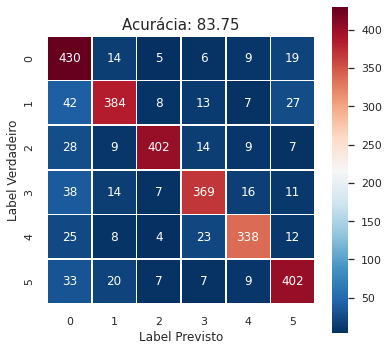

In [41]:
# Buscando todas as features do dataset apos o pre-processamento
all_features = [col for col in dados.columns if col != 'categoria']

# Separar target
X = dados[all_features]
y = dados['categoria']

# Realizando o balanceamento dos dados para cada classe usando SMOTE
sm = SMOTE(random_state=0)
X, y = sm.fit_sample(X, y)

# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Especificando as features categoricas para o modelo
cat_features = ['graduacao','profissao','organizacao','como_conheceu_lit','universidade']

# Preparando o dataset para o modelo
train_data = lgb2.Dataset(X_train, label=y_train, categorical_feature=cat_features, free_raw_data=False)
val_data   = lgb2.Dataset(X_test, label=y_test, categorical_feature=cat_features, free_raw_data=False)

lgb_params = {
    "objective"    : "multiclass",
    "metric"       : "multi_logloss",
    "verbosity"    : -1,
    "boosting_type": "gbdt",
    'num_class'    : 7
}

# Realizando o treinamento do modelo LGBM
modelo_lgb_v7 = lgb2.train(lgb_params, 
                           train_data, 
                           valid_sets=[train_data,val_data],
                           verbose_eval=100, 
                           early_stopping_rounds=100,)

# Previsões para cada classe com dados de teste
lgb_y_pred = np.rint(modelo_lgb_v7.predict(X_test, num_iteration=modelo_lgb_v7.best_iteration))

# Calcula o score com dados de teste
lgb_y_pred = [np.argmax(line) for line in lgb_y_pred]
lgb_score_v7 = accuracy_score(y_test, lgb_y_pred) * 100

# Print
print("Acurácia :", lgb_score_v7)

# Cria a matriz de confusão
conf_matriz_lgb = confusion_matrix(y_test, lgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_lgb = conf_matriz_lgb[0,0] / (conf_matriz_lgb[0,0] + conf_matriz_lgb[0,1])
sensi_lgb = conf_matriz_lgb[1,1] / (conf_matriz_lgb[1,0] + conf_matriz_lgb[1,1])

# Print
print('Sensibilidade :', sensi_lgb)
print('Especificidade :', speci_lgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_lgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(lgb_score_v7), size = 15)

# Relatório de Classificação
print(classification_report(y_test, lgb_y_pred))

# Exibindo os melhores parametros e desempenho do modelo
best_params = modelo_lgb_v7.params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

### LightGBM versão 08
> - Rodando a setima versao com todas as features criadas e apos a limpeza
> - Usando train_test_split com 20% dos dados para testes
> - Sem aplicar o balanceamento
> - Aplicando o MinMaxScaler
> - Realizando a otimização dos hyperparametros com Optuna


tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.477929	valid_1's multi_logloss: 0.774396
Early stopping, best iteration is:
[79]	training's multi_logloss: 0.528047	valid_1's multi_logloss: 0.771333



tune_feature_fraction, val_score: 0.771333:  14%|#4        | 1/7 [00:01<00:10,  1.68s/it][I 2020-08-30 18:04:22,261] Finished trial#0 with value: 0.7713329923109751 with parameters: {'feature_fraction': 0.4}. Best is trial#0 with value: 0.7713329923109751.

tune_feature_fraction, val_score: 0.771333:  14%|#4        | 1/7 [00:01<00:10,  1.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.460516	valid_1's multi_logloss: 0.773236
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.499301	valid_1's multi_logloss: 0.770068



tune_feature_fraction, val_score: 0.770068:  29%|##8       | 2/7 [00:03<00:08,  1.77s/it][I 2020-08-30 18:04:24,250] Finished trial#1 with value: 0.7700680080100953 with parameters: {'feature_fraction': 0.5}. Best is trial#1 with value: 0.7700680080100953.

tune_feature_fraction, val_score: 0.770068:  29%|##8       | 2/7 [00:03<00:08,  1.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.439974	valid_1's multi_logloss: 0.775671
Early stopping, best iteration is:
[59]	training's multi_logloss: 0.551985	valid_1's multi_logloss: 0.767519



tune_feature_fraction, val_score: 0.767519:  43%|####2     | 3/7 [00:05<00:07,  1.76s/it][I 2020-08-30 18:04:25,947] Finished trial#2 with value: 0.7675189173245492 with parameters: {'feature_fraction': 0.6}. Best is trial#2 with value: 0.7675189173245492.

tune_feature_fraction, val_score: 0.767519:  43%|####2     | 3/7 [00:05<00:07,  1.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.426329	valid_1's multi_logloss: 0.775711
Early stopping, best iteration is:
[54]	training's multi_logloss: 0.553657	valid_1's multi_logloss: 0.764159



tune_feature_fraction, val_score: 0.764159:  57%|#####7    | 4/7 [00:07<00:05,  1.72s/it][I 2020-08-30 18:04:27,578] Finished trial#3 with value: 0.7641590596752476 with parameters: {'feature_fraction': 0.7}. Best is trial#3 with value: 0.7641590596752476.

tune_feature_fraction, val_score: 0.764159:  57%|#####7    | 4/7 [00:07<00:05,  1.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.410932	valid_1's multi_logloss: 0.775099
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.56813	valid_1's multi_logloss: 0.75804



tune_feature_fraction, val_score: 0.758040:  71%|#######1  | 5/7 [00:08<00:03,  1.69s/it][I 2020-08-30 18:04:29,248] Finished trial#4 with value: 0.7580404777802592 with parameters: {'feature_fraction': 0.8}. Best is trial#4 with value: 0.7580404777802592.

tune_feature_fraction, val_score: 0.758040:  71%|#######1  | 5/7 [00:08<00:03,  1.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.404397	valid_1's multi_logloss: 0.775915
Early stopping, best iteration is:
[38]	training's multi_logloss: 0.591702	valid_1's multi_logloss: 0.757032



tune_feature_fraction, val_score: 0.757032:  86%|########5 | 6/7 [00:10<00:01,  1.65s/it][I 2020-08-30 18:04:30,777] Finished trial#5 with value: 0.7570320740246671 with parameters: {'feature_fraction': 0.8999999999999999}. Best is trial#5 with value: 0.7570320740246671.

tune_feature_fraction, val_score: 0.757032:  86%|########5 | 6/7 [00:10<00:01,  1.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.403553	valid_1's multi_logloss: 0.778188
Early stopping, best iteration is:
[38]	training's multi_logloss: 0.586836	valid_1's multi_logloss: 0.758501



tune_feature_fraction, val_score: 0.757032: 100%|##########| 7/7 [00:11<00:00,  1.71s/it]

tune_num_leaves, val_score: 0.757032:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0327004	valid_1's multi_logloss: 0.995393
Early stopping, best iteration is:
[32]	training's multi_logloss: 0.353111	valid_1's multi_logloss: 0.77319



tune_num_leaves, val_score: 0.757032:   5%|5         | 1/20 [00:07<02:23,  7.54s/it][I 2020-08-30 18:04:40,097] Finished trial#0 with value: 0.7731904970760911 with parameters: {'num_leaves': 251}. Best is trial#0 with value: 0.7731904970760911.

tune_num_leaves, val_score: 0.757032:   5%|5         | 1/20 [00:07<02:23,  7.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0725372	valid_1's multi_logloss: 0.916585
Early stopping, best iteration is:
[32]	training's multi_logloss: 0.401397	valid_1's multi_logloss: 0.769888



tune_num_leaves, val_score: 0.757032:  10%|#         | 2/20 [00:12<02:03,  6.86s/it][I 2020-08-30 18:04:45,367] Finished trial#1 with value: 0.7698877207246816 with parameters: {'num_leaves': 147}. Best is trial#1 with value: 0.7698877207246816.

tune_num_leaves, val_score: 0.757032:  10%|#         | 2/20 [00:13<02:03,  6.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.056091	valid_1's multi_logloss: 0.942913
Early stopping, best iteration is:
[33]	training's multi_logloss: 0.370685	valid_1's multi_logloss: 0.772721



tune_num_leaves, val_score: 0.757032:  15%|#5        | 3/20 [00:18<01:51,  6.55s/it][I 2020-08-30 18:04:51,210] Finished trial#2 with value: 0.7727213728639216 with parameters: {'num_leaves': 169}. Best is trial#1 with value: 0.7698877207246816.

tune_num_leaves, val_score: 0.757032:  15%|#5        | 3/20 [00:18<01:51,  6.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0445102	valid_1's multi_logloss: 0.970691
Early stopping, best iteration is:
[31]	training's multi_logloss: 0.378365	valid_1's multi_logloss: 0.771517



tune_num_leaves, val_score: 0.757032:  20%|##        | 4/20 [00:25<01:45,  6.59s/it][I 2020-08-30 18:04:57,885] Finished trial#3 with value: 0.771517283473317 with parameters: {'num_leaves': 196}. Best is trial#1 with value: 0.7698877207246816.

tune_num_leaves, val_score: 0.757032:  20%|##        | 4/20 [00:25<01:45,  6.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.205363	valid_1's multi_logloss: 0.820316
Early stopping, best iteration is:
[39]	training's multi_logloss: 0.459901	valid_1's multi_logloss: 0.764116



tune_num_leaves, val_score: 0.757032:  25%|##5       | 5/20 [00:28<01:24,  5.61s/it][I 2020-08-30 18:05:01,219] Finished trial#4 with value: 0.7641161293491507 with parameters: {'num_leaves': 73}. Best is trial#4 with value: 0.7641161293491507.

tune_num_leaves, val_score: 0.757032:  25%|##5       | 5/20 [00:28<01:24,  5.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.364644	valid_1's multi_logloss: 0.783322
Early stopping, best iteration is:
[36]	training's multi_logloss: 0.580236	valid_1's multi_logloss: 0.759198



tune_num_leaves, val_score: 0.757032:  30%|###       | 6/20 [00:30<01:03,  4.52s/it][I 2020-08-30 18:05:03,205] Finished trial#5 with value: 0.7591981286356445 with parameters: {'num_leaves': 37}. Best is trial#5 with value: 0.7591981286356445.

tune_num_leaves, val_score: 0.757032:  30%|###       | 6/20 [00:30<01:03,  4.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0645479	valid_1's multi_logloss: 0.93041
Early stopping, best iteration is:
[31]	training's multi_logloss: 0.402915	valid_1's multi_logloss: 0.771997



tune_num_leaves, val_score: 0.757032:  35%|###5      | 7/20 [00:35<01:01,  4.77s/it][I 2020-08-30 18:05:08,537] Finished trial#6 with value: 0.7719969702285815 with parameters: {'num_leaves': 157}. Best is trial#5 with value: 0.7591981286356445.

tune_num_leaves, val_score: 0.757032:  35%|###5      | 7/20 [00:36<01:01,  4.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.048265	valid_1's multi_logloss: 0.955923
Early stopping, best iteration is:
[32]	training's multi_logloss: 0.3724	valid_1's multi_logloss: 0.772262



tune_num_leaves, val_score: 0.757032:  40%|####      | 8/20 [00:42<01:02,  5.17s/it][I 2020-08-30 18:05:14,634] Finished trial#7 with value: 0.7722622700452143 with parameters: {'num_leaves': 184}. Best is trial#5 with value: 0.7591981286356445.

tune_num_leaves, val_score: 0.757032:  40%|####      | 8/20 [00:42<01:02,  5.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.131086	valid_1's multi_logloss: 0.861488
Early stopping, best iteration is:
[35]	training's multi_logloss: 0.431842	valid_1's multi_logloss: 0.766596



tune_num_leaves, val_score: 0.757032:  45%|####5     | 9/20 [00:45<00:52,  4.77s/it][I 2020-08-30 18:05:18,418] Finished trial#8 with value: 0.7665962874924395 with parameters: {'num_leaves': 103}. Best is trial#5 with value: 0.7591981286356445.

tune_num_leaves, val_score: 0.757032:  45%|####5     | 9/20 [00:46<00:52,  4.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.162906	valid_1's multi_logloss: 0.842627
Early stopping, best iteration is:
[39]	training's multi_logloss: 0.427637	valid_1's multi_logloss: 0.764117



tune_num_leaves, val_score: 0.757032:  50%|#####     | 10/20 [00:49<00:43,  4.39s/it][I 2020-08-30 18:05:21,896] Finished trial#9 with value: 0.764117184369997 with parameters: {'num_leaves': 88}. Best is trial#5 with value: 0.7591981286356445.

tune_num_leaves, val_score: 0.757032:  50%|#####     | 10/20 [00:49<00:43,  4.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.601102	valid_1's multi_logloss: 0.756864
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.671165	valid_1's multi_logloss: 0.750939



tune_num_leaves, val_score: 0.750939:  55%|#####5    | 11/20 [00:50<00:29,  3.32s/it][I 2020-08-30 18:05:22,746] Finished trial#10 with value: 0.7509388504339068 with parameters: {'num_leaves': 10}. Best is trial#10 with value: 0.7509388504339068.

tune_num_leaves, val_score: 0.750939:  55%|#####5    | 11/20 [00:50<00:29,  3.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.676396	valid_1's multi_logloss: 0.759351
Early stopping, best iteration is:
[42]	training's multi_logloss: 0.713748	valid_1's multi_logloss: 0.757312



tune_num_leaves, val_score: 0.750939:  60%|######    | 12/20 [00:50<00:20,  2.51s/it][I 2020-08-30 18:05:23,354] Finished trial#11 with value: 0.7573119821350167 with parameters: {'num_leaves': 5}. Best is trial#10 with value: 0.7509388504339068.

tune_num_leaves, val_score: 0.750939:  60%|######    | 12/20 [00:51<00:20,  2.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.658765	valid_1's multi_logloss: 0.755408
Early stopping, best iteration is:
[50]	training's multi_logloss: 0.695565	valid_1's multi_logloss: 0.752239



tune_num_leaves, val_score: 0.750939:  65%|######5   | 13/20 [00:51<00:13,  1.96s/it][I 2020-08-30 18:05:24,031] Finished trial#12 with value: 0.7522387703528001 with parameters: {'num_leaves': 6}. Best is trial#10 with value: 0.7509388504339068.

tune_num_leaves, val_score: 0.750939:  65%|######5   | 13/20 [00:51<00:13,  1.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.785477	valid_1's multi_logloss: 0.815788
[200]	training's multi_logloss: 0.754148	valid_1's multi_logloss: 0.795083
[300]	training's multi_logloss: 0.745838	valid_1's multi_logloss: 0.791259
[400]	training's multi_logloss: 0.740699	valid_1's multi_logloss: 0.789561
[500]	training's multi_logloss: 0.736944	valid_1's multi_logloss: 0.788584
[600]	training's multi_logloss: 0.73398	valid_1's multi_logloss: 0.788091
[700]	training's multi_logloss: 0.731519	valid_1's multi_logloss: 0.787869
[800]	training's multi_logloss: 0.729387	valid_1's multi_logloss: 0.787763
[900]	training's multi_logloss: 0.727475	valid_1's multi_logloss: 0.787747
[1000]	training's multi_logloss: 0.725737	valid_1's multi_logloss: 0.787662
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.725737	valid_1's multi_logloss: 0.787662



tune_num_leaves, val_score: 0.750939:  70%|#######   | 14/20 [00:53<00:11,  1.87s/it][I 2020-08-30 18:05:25,709] Finished trial#13 with value: 0.7876616885384101 with parameters: {'num_leaves': 2}. Best is trial#10 with value: 0.7509388504339068.

tune_num_leaves, val_score: 0.750939:  70%|#######   | 14/20 [00:53<00:11,  1.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.336568	valid_1's multi_logloss: 0.786827
Early stopping, best iteration is:
[39]	training's multi_logloss: 0.547908	valid_1's multi_logloss: 0.758552



tune_num_leaves, val_score: 0.750939:  75%|#######5  | 15/20 [00:55<00:09,  1.93s/it][I 2020-08-30 18:05:27,834] Finished trial#14 with value: 0.758552178495715 with parameters: {'num_leaves': 42}. Best is trial#10 with value: 0.7509388504339068.

tune_num_leaves, val_score: 0.750939:  75%|#######5  | 15/20 [00:55<00:09,  1.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.3985	valid_1's multi_logloss: 0.776742
Early stopping, best iteration is:
[38]	training's multi_logloss: 0.587573	valid_1's multi_logloss: 0.756898



tune_num_leaves, val_score: 0.750939:  80%|########  | 16/20 [00:56<00:07,  1.85s/it][I 2020-08-30 18:05:29,442] Finished trial#15 with value: 0.7568982328606739 with parameters: {'num_leaves': 32}. Best is trial#10 with value: 0.7509388504339068.

tune_num_leaves, val_score: 0.750939:  80%|########  | 16/20 [00:57<00:07,  1.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.785477	valid_1's multi_logloss: 0.815788
[200]	training's multi_logloss: 0.754148	valid_1's multi_logloss: 0.795083
[300]	training's multi_logloss: 0.745838	valid_1's multi_logloss: 0.791259
[400]	training's multi_logloss: 0.740699	valid_1's multi_logloss: 0.789561
[500]	training's multi_logloss: 0.736944	valid_1's multi_logloss: 0.788584
[600]	training's multi_logloss: 0.73398	valid_1's multi_logloss: 0.788091
[700]	training's multi_logloss: 0.731519	valid_1's multi_logloss: 0.787869
[800]	training's multi_logloss: 0.729387	valid_1's multi_logloss: 0.787763
[900]	training's multi_logloss: 0.727475	valid_1's multi_logloss: 0.787747
[1000]	training's multi_logloss: 0.725737	valid_1's multi_logloss: 0.787662
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.725737	valid_1's multi_logloss: 0.787662



tune_num_leaves, val_score: 0.750939:  85%|########5 | 17/20 [00:58<00:05,  1.82s/it][I 2020-08-30 18:05:31,266] Finished trial#16 with value: 0.78766168853841 with parameters: {'num_leaves': 2}. Best is trial#10 with value: 0.7509388504339068.

tune_num_leaves, val_score: 0.750939:  85%|########5 | 17/20 [00:58<00:05,  1.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.243925	valid_1's multi_logloss: 0.81035
Early stopping, best iteration is:
[39]	training's multi_logloss: 0.490544	valid_1's multi_logloss: 0.763481



tune_num_leaves, val_score: 0.750939:  90%|######### | 18/20 [01:01<00:04,  2.09s/it][I 2020-08-30 18:05:33,941] Finished trial#17 with value: 0.7634809517574086 with parameters: {'num_leaves': 62}. Best is trial#10 with value: 0.7509388504339068.

tune_num_leaves, val_score: 0.750939:  90%|######### | 18/20 [01:01<00:04,  2.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.127141	valid_1's multi_logloss: 0.860598
Early stopping, best iteration is:
[35]	training's multi_logloss: 0.428624	valid_1's multi_logloss: 0.767046



tune_num_leaves, val_score: 0.750939:  95%|#########5| 19/20 [01:05<00:02,  2.71s/it][I 2020-08-30 18:05:38,119] Finished trial#18 with value: 0.7670463267378632 with parameters: {'num_leaves': 105}. Best is trial#10 with value: 0.7509388504339068.

tune_num_leaves, val_score: 0.750939:  95%|#########5| 19/20 [01:05<00:02,  2.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0373175	valid_1's multi_logloss: 0.978943
Early stopping, best iteration is:
[30]	training's multi_logloss: 0.381962	valid_1's multi_logloss: 0.775838



tune_num_leaves, val_score: 0.750939: 100%|##########| 20/20 [01:12<00:00,  3.64s/it]

  0%|          | 0/10 [00:00<?, ?it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.750939:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.595597	valid_1's multi_logloss: 0.763327
Early stopping, best iteration is:
[49]	training's multi_logloss: 0.664909	valid_1's multi_logloss: 0.756385



tune_bagging_fraction_and_bagging_freq, val_score: 0.750939:   0%|          | 0/10 [00:00<?, ?it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.750939:  10%|#         | 1/10 [00:00<00:05,  1.51it/s][I 2020-08-30 18:05:45,962] Finished trial#0 with value: 0.7563846453840509 with parameters: {'bagging_fraction': 0.45944376928955544, 'bagging_freq': 2}. Best is trial#0 with value: 0.7563846453840509.

tune_bagging_fraction_and_bagging_freq, val_score: 0.750939:  10%|#         | 1/10 [00:00<00:05,  1.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.598426	valid_1's multi_logloss: 0.756649
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.670776	valid_1's multi_logloss: 0.7497



tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  10%|#         | 1/10 [00:01<00:05,  1.51it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  20%|##        | 2/10 [00:01<00:05,  1.39it/s][I 2020-08-30 18:05:46,817] Finished trial#1 with value: 0.7496996721788356 with parameters: {'bagging_fraction': 0.9602635961870527, 'bagging_freq': 4}. Best is trial#1 with value: 0.7496996721788356.

tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  20%|##        | 2/10 [00:01<00:05,  1.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.593491	valid_1's multi_logloss: 0.760132
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.666869	valid_1's multi_logloss: 0.75088



tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  20%|##        | 2/10 [00:02<00:05,  1.39it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  30%|###       | 3/10 [00:02<00:05,  1.33it/s][I 2020-08-30 18:05:47,639] Finished trial#2 with value: 0.750879904111995 with parameters: {'bagging_fraction': 0.6545298707849694, 'bagging_freq': 2}. Best is trial#1 with value: 0.7496996721788356.

tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  30%|###       | 3/10 [00:02<00:05,  1.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.597027	valid_1's multi_logloss: 0.766057
Early stopping, best iteration is:
[37]	training's multi_logloss: 0.684432	valid_1's multi_logloss: 0.754219



tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  30%|###       | 3/10 [00:03<00:05,  1.33it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  40%|####      | 4/10 [00:03<00:04,  1.34it/s][I 2020-08-30 18:05:48,366] Finished trial#3 with value: 0.754218845651001 with parameters: {'bagging_fraction': 0.5955765708479739, 'bagging_freq': 4}. Best is trial#1 with value: 0.7496996721788356.

tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  40%|####      | 4/10 [00:03<00:04,  1.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.59704	valid_1's multi_logloss: 0.759323
Early stopping, best iteration is:
[41]	training's multi_logloss: 0.677487	valid_1's multi_logloss: 0.751016



tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  40%|####      | 4/10 [00:03<00:04,  1.34it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  50%|#####     | 5/10 [00:03<00:03,  1.30it/s][I 2020-08-30 18:05:49,234] Finished trial#4 with value: 0.751015714591441 with parameters: {'bagging_fraction': 0.9246242606573206, 'bagging_freq': 3}. Best is trial#1 with value: 0.7496996721788356.

tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  50%|#####     | 5/10 [00:04<00:03,  1.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.59831	valid_1's multi_logloss: 0.766828
Early stopping, best iteration is:
[51]	training's multi_logloss: 0.662242	valid_1's multi_logloss: 0.756328



tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  50%|#####     | 5/10 [00:04<00:03,  1.30it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  60%|######    | 6/10 [00:04<00:03,  1.22it/s][I 2020-08-30 18:05:50,140] Finished trial#5 with value: 0.7563277493891275 with parameters: {'bagging_fraction': 0.5621461333978008, 'bagging_freq': 5}. Best is trial#1 with value: 0.7496996721788356.

tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  60%|######    | 6/10 [00:05<00:03,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.598114	valid_1's multi_logloss: 0.767573
Early stopping, best iteration is:
[40]	training's multi_logloss: 0.679026	valid_1's multi_logloss: 0.758219



tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  60%|######    | 6/10 [00:05<00:03,  1.22it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  70%|#######   | 7/10 [00:05<00:02,  1.25it/s][I 2020-08-30 18:05:50,879] Finished trial#6 with value: 0.7582186335664167 with parameters: {'bagging_fraction': 0.46629000023449596, 'bagging_freq': 3}. Best is trial#1 with value: 0.7496996721788356.

tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  70%|#######   | 7/10 [00:05<00:02,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.596784	valid_1's multi_logloss: 0.760189
Early stopping, best iteration is:
[40]	training's multi_logloss: 0.68077	valid_1's multi_logloss: 0.75129



tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  70%|#######   | 7/10 [00:06<00:02,  1.25it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  80%|########  | 8/10 [00:06<00:01,  1.25it/s][I 2020-08-30 18:05:51,680] Finished trial#7 with value: 0.7512904307223751 with parameters: {'bagging_fraction': 0.9140469780806741, 'bagging_freq': 5}. Best is trial#1 with value: 0.7496996721788356.

tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  80%|########  | 8/10 [00:06<00:01,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.599227	valid_1's multi_logloss: 0.759898
Early stopping, best iteration is:
[41]	training's multi_logloss: 0.679139	valid_1's multi_logloss: 0.750487



tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  80%|########  | 8/10 [00:07<00:01,  1.25it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  90%|######### | 9/10 [00:07<00:00,  1.25it/s][I 2020-08-30 18:05:52,492] Finished trial#8 with value: 0.750487290575184 with parameters: {'bagging_fraction': 0.9532589038203393, 'bagging_freq': 7}. Best is trial#1 with value: 0.7496996721788356.

tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  90%|######### | 9/10 [00:07<00:00,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.596617	valid_1's multi_logloss: 0.761441
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.670228	valid_1's multi_logloss: 0.754225



tune_bagging_fraction_and_bagging_freq, val_score: 0.749700:  90%|######### | 9/10 [00:07<00:00,  1.25it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.749700: 100%|##########| 10/10 [00:07<00:00,  1.25it/s][I 2020-08-30 18:05:53,278] Finished trial#9 with value: 0.7542245808368707 with parameters: {'bagging_fraction': 0.7030116728030807, 'bagging_freq': 6}. Best is trial#1 with value: 0.7496996721788356.
tune_bagging_fraction_and_bagging_freq, val_score: 0.749700: 100%|##########| 10/10 [00:08<00:00,  1.23it/s]

tune_feature_fraction, val_score: 0.749700:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.601504	valid_1's multi_logloss: 0.759327
Early stopping, best iteration is:
[51]	training's multi_logloss: 0.665251	valid_1's multi_logloss: 0.751862



tune_feature_fraction, val_score: 0.749700:  17%|#6        | 1/6 [00:00<00:04,  1.20it/s][I 2020-08-30 18:05:54,300] Finished trial#0 with value: 0.7518621233333119 with parameters: {'feature_fraction': 0.82}. Best is trial#0 with value: 0.7518621233333119.

tune_feature_fraction, val_score: 0.749700:  17%|#6        | 1/6 [00:01<00:04,  1.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.601504	valid_1's multi_logloss: 0.759327
Early stopping, best iteration is:
[51]	training's multi_logloss: 0.665251	valid_1's multi_logloss: 0.751862



tune_feature_fraction, val_score: 0.749700:  33%|###3      | 2/6 [00:01<00:03,  1.13it/s][I 2020-08-30 18:05:55,308] Finished trial#1 with value: 0.7518621233333118 with parameters: {'feature_fraction': 0.852}. Best is trial#1 with value: 0.7518621233333118.

tune_feature_fraction, val_score: 0.749700:  33%|###3      | 2/6 [00:02<00:03,  1.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.598426	valid_1's multi_logloss: 0.756649
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.670776	valid_1's multi_logloss: 0.7497



tune_feature_fraction, val_score: 0.749700:  50%|#####     | 3/6 [00:02<00:02,  1.14it/s][I 2020-08-30 18:05:56,181] Finished trial#2 with value: 0.7496996721788355 with parameters: {'feature_fraction': 0.8839999999999999}. Best is trial#2 with value: 0.7496996721788355.

tune_feature_fraction, val_score: 0.749700:  50%|#####     | 3/6 [00:02<00:02,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.598426	valid_1's multi_logloss: 0.756649
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.670776	valid_1's multi_logloss: 0.7497



tune_feature_fraction, val_score: 0.749700:  67%|######6   | 4/6 [00:03<00:01,  1.15it/s][I 2020-08-30 18:05:57,014] Finished trial#3 with value: 0.7496996721788357 with parameters: {'feature_fraction': 0.9159999999999999}. Best is trial#2 with value: 0.7496996721788355.

tune_feature_fraction, val_score: 0.749700:  67%|######6   | 4/6 [00:03<00:01,  1.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.598426	valid_1's multi_logloss: 0.756649
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.670776	valid_1's multi_logloss: 0.7497



tune_feature_fraction, val_score: 0.749700:  83%|########3 | 5/6 [00:04<00:00,  1.16it/s][I 2020-08-30 18:05:57,874] Finished trial#4 with value: 0.7496996721788356 with parameters: {'feature_fraction': 0.948}. Best is trial#2 with value: 0.7496996721788355.

tune_feature_fraction, val_score: 0.749700:  83%|########3 | 5/6 [00:04<00:00,  1.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.59444	valid_1's multi_logloss: 0.757621
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.666151	valid_1's multi_logloss: 0.749513



tune_feature_fraction, val_score: 0.749513: 100%|##########| 6/6 [00:05<00:00,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749513:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.59444	valid_1's multi_logloss: 0.757621
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.666151	valid_1's multi_logloss: 0.749513



tune_lambda_l1_and_lambda_l2, val_score: 0.749513:   0%|          | 0/20 [00:00<?, ?it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749513:   5%|5         | 1/20 [00:00<00:12,  1.50it/s][I 2020-08-30 18:05:59,622] Finished trial#0 with value: 0.7495131936674402 with parameters: {'lambda_l1': 5.522086560213619e-07, 'lambda_l2': 5.764950971048233e-07}. Best is trial#0 with value: 0.7495131936674402.

tune_lambda_l1_and_lambda_l2, val_score: 0.749513:   5%|5         | 1/20 [00:00<00:12,  1.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.59444	valid_1's multi_logloss: 0.757621
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.666151	valid_1's multi_logloss: 0.749513



tune_lambda_l1_and_lambda_l2, val_score: 0.749513:   5%|5         | 1/20 [00:01<00:12,  1.50it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749513:  10%|#         | 2/20 [00:01<00:13,  1.35it/s][I 2020-08-30 18:06:00,538] Finished trial#1 with value: 0.7495131936410754 with parameters: {'lambda_l1': 4.196704467135416e-08, 'lambda_l2': 8.406843378182911e-07}. Best is trial#1 with value: 0.7495131936410754.

tune_lambda_l1_and_lambda_l2, val_score: 0.749513:  10%|#         | 2/20 [00:01<00:13,  1.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.610868	valid_1's multi_logloss: 0.756675
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.675244	valid_1's multi_logloss: 0.750386



tune_lambda_l1_and_lambda_l2, val_score: 0.749513:  10%|#         | 2/20 [00:02<00:13,  1.35it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749513:  15%|#5        | 3/20 [00:02<00:13,  1.23it/s][I 2020-08-30 18:06:01,514] Finished trial#2 with value: 0.7503861789397129 with parameters: {'lambda_l1': 3.654328774845489e-08, 'lambda_l2': 1.124783268248916}. Best is trial#1 with value: 0.7495131936410754.

tune_lambda_l1_and_lambda_l2, val_score: 0.749513:  15%|#5        | 3/20 [00:02<00:13,  1.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.608749	valid_1's multi_logloss: 0.757053
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.672071	valid_1's multi_logloss: 0.74949



tune_lambda_l1_and_lambda_l2, val_score: 0.749490:  15%|#5        | 3/20 [00:03<00:13,  1.23it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749490:  20%|##        | 4/20 [00:03<00:13,  1.18it/s][I 2020-08-30 18:06:02,454] Finished trial#3 with value: 0.749490179213863 with parameters: {'lambda_l1': 0.004272495600323334, 'lambda_l2': 1.0542793388482805}. Best is trial#3 with value: 0.749490179213863.

tune_lambda_l1_and_lambda_l2, val_score: 0.749490:  20%|##        | 4/20 [00:03<00:13,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.660222	valid_1's multi_logloss: 0.758682
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.69875	valid_1's multi_logloss: 0.753655



tune_lambda_l1_and_lambda_l2, val_score: 0.749490:  20%|##        | 4/20 [00:04<00:13,  1.18it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749490:  25%|##5       | 5/20 [00:04<00:12,  1.18it/s][I 2020-08-30 18:06:03,308] Finished trial#4 with value: 0.7536552767381341 with parameters: {'lambda_l1': 5.026697790423521, 'lambda_l2': 0.0037368148766616896}. Best is trial#3 with value: 0.749490179213863.

tune_lambda_l1_and_lambda_l2, val_score: 0.749490:  25%|##5       | 5/20 [00:04<00:12,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.594521	valid_1's multi_logloss: 0.757756
Early stopping, best iteration is:
[48]	training's multi_logloss: 0.664592	valid_1's multi_logloss: 0.749471



tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  25%|##5       | 5/20 [00:05<00:12,  1.18it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  30%|###       | 6/20 [00:05<00:11,  1.18it/s][I 2020-08-30 18:06:04,155] Finished trial#5 with value: 0.7494707814012799 with parameters: {'lambda_l1': 0.0007148935852485172, 'lambda_l2': 3.538030259528569e-05}. Best is trial#5 with value: 0.7494707814012799.

tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  30%|###       | 6/20 [00:05<00:11,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.594973	valid_1's multi_logloss: 0.758426
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.669587	valid_1's multi_logloss: 0.74964



tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  30%|###       | 6/20 [00:06<00:11,  1.18it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  35%|###5      | 7/20 [00:06<00:11,  1.16it/s][I 2020-08-30 18:06:05,056] Finished trial#6 with value: 0.7496399711139818 with parameters: {'lambda_l1': 1.2979261358634652e-07, 'lambda_l2': 0.003965139452328826}. Best is trial#5 with value: 0.7494707814012799.

tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  35%|###5      | 7/20 [00:06<00:11,  1.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.595071	valid_1's multi_logloss: 0.758114
Early stopping, best iteration is:
[48]	training's multi_logloss: 0.664987	valid_1's multi_logloss: 0.749858



tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  35%|###5      | 7/20 [00:06<00:11,  1.16it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  40%|####      | 8/20 [00:06<00:10,  1.14it/s][I 2020-08-30 18:06:05,953] Finished trial#7 with value: 0.7498584402472007 with parameters: {'lambda_l1': 0.0006031535517906026, 'lambda_l2': 0.0032091866934051954}. Best is trial#5 with value: 0.7494707814012799.

tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  40%|####      | 8/20 [00:07<00:10,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.60695	valid_1's multi_logloss: 0.756586
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.674124	valid_1's multi_logloss: 0.749843



tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  40%|####      | 8/20 [00:07<00:10,  1.14it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  45%|####5     | 9/20 [00:07<00:09,  1.16it/s][I 2020-08-30 18:06:06,816] Finished trial#8 with value: 0.7498428738666234 with parameters: {'lambda_l1': 2.184711037418563e-08, 'lambda_l2': 0.8630820716390877}. Best is trial#5 with value: 0.7494707814012799.

tune_lambda_l1_and_lambda_l2, val_score: 0.749471:  45%|####5     | 9/20 [00:08<00:09,  1.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.596909	valid_1's multi_logloss: 0.757318
Early stopping, best iteration is:
[48]	training's multi_logloss: 0.66591	valid_1's multi_logloss: 0.749337



tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  45%|####5     | 9/20 [00:08<00:09,  1.16it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  50%|#####     | 10/20 [00:08<00:08,  1.15it/s][I 2020-08-30 18:06:07,734] Finished trial#9 with value: 0.7493371608243349 with parameters: {'lambda_l1': 0.16686353735920975, 'lambda_l2': 4.136915677217149e-07}. Best is trial#9 with value: 0.7493371608243349.

tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  50%|#####     | 10/20 [00:08<00:08,  1.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.627039	valid_1's multi_logloss: 0.758696
Early stopping, best iteration is:
[43]	training's multi_logloss: 0.687047	valid_1's multi_logloss: 0.751353



tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  50%|#####     | 10/20 [00:09<00:08,  1.15it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  55%|#####5    | 11/20 [00:09<00:07,  1.14it/s][I 2020-08-30 18:06:08,576] Finished trial#10 with value: 0.7513528806598124 with parameters: {'lambda_l1': 1.8924204049797428, 'lambda_l2': 4.447805897302651e-08}. Best is trial#9 with value: 0.7493371608243349.

tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  55%|#####5    | 11/20 [00:09<00:07,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.59494	valid_1's multi_logloss: 0.757703
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.666712	valid_1's multi_logloss: 0.750062



tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  55%|#####5    | 11/20 [00:10<00:07,  1.14it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  60%|######    | 12/20 [00:10<00:07,  1.13it/s][I 2020-08-30 18:06:09,466] Finished trial#11 with value: 0.7500615050153778 with parameters: {'lambda_l1': 0.030748047477521197, 'lambda_l2': 2.9344638919325875e-05}. Best is trial#9 with value: 0.7493371608243349.

tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  60%|######    | 12/20 [00:10<00:07,  1.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.59444	valid_1's multi_logloss: 0.75762
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.666151	valid_1's multi_logloss: 0.749513



tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  60%|######    | 12/20 [00:11<00:07,  1.13it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  65%|######5   | 13/20 [00:11<00:06,  1.13it/s][I 2020-08-30 18:06:10,348] Finished trial#12 with value: 0.7495131800700373 with parameters: {'lambda_l1': 9.646631059557699e-06, 'lambda_l2': 2.198331863087356e-05}. Best is trial#9 with value: 0.7493371608243349.

tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  65%|######5   | 13/20 [00:11<00:06,  1.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.595923	valid_1's multi_logloss: 0.757926
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.666844	valid_1's multi_logloss: 0.749779



tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  65%|######5   | 13/20 [00:12<00:06,  1.13it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  70%|#######   | 14/20 [00:12<00:05,  1.15it/s][I 2020-08-30 18:06:11,197] Finished trial#13 with value: 0.7497793504628725 with parameters: {'lambda_l1': 0.041215580430242794, 'lambda_l2': 2.6035946408306702e-08}. Best is trial#9 with value: 0.7493371608243349.

tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  70%|#######   | 14/20 [00:12<00:05,  1.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.594441	valid_1's multi_logloss: 0.75762
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.666151	valid_1's multi_logloss: 0.749513



tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  70%|#######   | 14/20 [00:13<00:05,  1.15it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  75%|#######5  | 15/20 [00:13<00:04,  1.13it/s][I 2020-08-30 18:06:12,107] Finished trial#14 with value: 0.749513176220026 with parameters: {'lambda_l1': 2.7782150460168063e-05, 'lambda_l2': 2.196486891730233e-05}. Best is trial#9 with value: 0.7493371608243349.

tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  75%|#######5  | 15/20 [00:13<00:04,  1.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.598634	valid_1's multi_logloss: 0.757029
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.671826	valid_1's multi_logloss: 0.750017



tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  75%|#######5  | 15/20 [00:14<00:04,  1.13it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  80%|########  | 16/20 [00:14<00:03,  1.09it/s][I 2020-08-30 18:06:13,100] Finished trial#15 with value: 0.7500173538659713 with parameters: {'lambda_l1': 0.2954981241856958, 'lambda_l2': 3.594000708681743e-07}. Best is trial#9 with value: 0.7493371608243349.

tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  80%|########  | 16/20 [00:14<00:03,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.594523	valid_1's multi_logloss: 0.757755
Early stopping, best iteration is:
[48]	training's multi_logloss: 0.664593	valid_1's multi_logloss: 0.749471



tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  80%|########  | 16/20 [00:14<00:03,  1.09it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  85%|########5 | 17/20 [00:14<00:02,  1.11it/s][I 2020-08-30 18:06:13,951] Finished trial#16 with value: 0.7494707366575926 with parameters: {'lambda_l1': 0.0006344254745615904, 'lambda_l2': 0.0001914809213860468}. Best is trial#9 with value: 0.7493371608243349.

tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  85%|########5 | 17/20 [00:15<00:02,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.59445	valid_1's multi_logloss: 0.75762
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.666154	valid_1's multi_logloss: 0.749513



tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  85%|########5 | 17/20 [00:15<00:02,  1.11it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  90%|######### | 18/20 [00:15<00:01,  1.13it/s][I 2020-08-30 18:06:14,815] Finished trial#17 with value: 0.7495129627129442 with parameters: {'lambda_l1': 3.4815903390136106e-05, 'lambda_l2': 0.00041084398455772174}. Best is trial#9 with value: 0.7493371608243349.

tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  90%|######### | 18/20 [00:16<00:01,  1.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.595787	valid_1's multi_logloss: 0.757249
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.668612	valid_1's multi_logloss: 0.749587



tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  90%|######### | 18/20 [00:16<00:01,  1.13it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  95%|#########5| 19/20 [00:16<00:00,  1.14it/s][I 2020-08-30 18:06:15,657] Finished trial#18 with value: 0.7495869385164012 with parameters: {'lambda_l1': 0.008033495267713325, 'lambda_l2': 0.08165332738176752}. Best is trial#9 with value: 0.7493371608243349.

tune_lambda_l1_and_lambda_l2, val_score: 0.749337:  95%|#########5| 19/20 [00:16<00:00,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.601221	valid_1's multi_logloss: 0.75877
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.669506	valid_1's multi_logloss: 0.749188



tune_lambda_l1_and_lambda_l2, val_score: 0.749188:  95%|#########5| 19/20 [00:17<00:00,  1.14it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.749188: 100%|##########| 20/20 [00:17<00:00,  1.15it/s][I 2020-08-30 18:06:16,509] Finished trial#19 with value: 0.7491879607144549 with parameters: {'lambda_l1': 0.39611525203417386, 'lambda_l2': 2.520849648616546e-06}. Best is trial#19 with value: 0.7491879607144549.
tune_lambda_l1_and_lambda_l2, val_score: 0.749188: 100%|##########| 20/20 [00:17<00:00,  1.13it/s]

tune_min_child_samples, val_score: 0.749188:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.582433	valid_1's multi_logloss: 0.758737
Early stopping, best iteration is:
[42]	training's multi_logloss: 0.671902	valid_1's multi_logloss: 0.748765



tune_min_child_samples, val_score: 0.748765:  20%|##        | 1/5 [00:00<00:02,  1.43it/s][I 2020-08-30 18:06:17,384] Finished trial#0 with value: 0.7487652730581799 with parameters: {'min_child_samples': 5}. Best is trial#0 with value: 0.7487652730581799.

tune_min_child_samples, val_score: 0.748765:  20%|##        | 1/5 [00:00<00:02,  1.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.590125	valid_1's multi_logloss: 0.757149
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.667567	valid_1's multi_logloss: 0.748526



tune_min_child_samples, val_score: 0.748526:  40%|####      | 2/5 [00:01<00:02,  1.32it/s][I 2020-08-30 18:06:18,285] Finished trial#1 with value: 0.7485261562086739 with parameters: {'min_child_samples': 10}. Best is trial#1 with value: 0.7485261562086739.

tune_min_child_samples, val_score: 0.748526:  40%|####      | 2/5 [00:01<00:02,  1.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.603876	valid_1's multi_logloss: 0.757015
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.673782	valid_1's multi_logloss: 0.749741



tune_min_child_samples, val_score: 0.748526:  60%|######    | 3/5 [00:02<00:01,  1.25it/s][I 2020-08-30 18:06:19,172] Finished trial#2 with value: 0.7497407163845566 with parameters: {'min_child_samples': 25}. Best is trial#1 with value: 0.7485261562086739.

tune_min_child_samples, val_score: 0.748526:  60%|######    | 3/5 [00:02<00:01,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.614548	valid_1's multi_logloss: 0.757618
Early stopping, best iteration is:
[48]	training's multi_logloss: 0.67371	valid_1's multi_logloss: 0.750084



tune_min_child_samples, val_score: 0.748526:  80%|########  | 4/5 [00:03<00:00,  1.23it/s][I 2020-08-30 18:06:20,020] Finished trial#3 with value: 0.7500842873291539 with parameters: {'min_child_samples': 50}. Best is trial#1 with value: 0.7485261562086739.

tune_min_child_samples, val_score: 0.748526:  80%|########  | 4/5 [00:03<00:00,  1.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.62627	valid_1's multi_logloss: 0.758128
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.681757	valid_1's multi_logloss: 0.75038



tune_min_child_samples, val_score: 0.748526: 100%|##########| 5/5 [00:04<00:00,  1.15it/s]


Acurácia : 79.50253339474897
Sensibilidade : 0.9097888675623801
Especificidade : 0.9313725490196079


              precision    recall  f1-score   support

           0       0.65      0.82      0.72       349
           1       0.85      0.82      0.83       581
           2       0.72      0.65      0.68       124
           3       0.80      0.69      0.74       230
           4       0.84      0.75      0.80       267
           5       0.84      0.85      0.84       620

    accuracy                           0.80      2171
   macro avg       0.78      0.76      0.77      2171
weighted avg       0.80      0.80      0.80      2171

Best params: {'objective': 'multiclass', 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_class': 7, 'lambda_l1': 0.39611525203417386, 'lambda_l2': 2.520849648616546e-06, 'num_leaves': 10, 'feature_fraction': 0.9799999999999999, 'bagging_fraction': 0.9602635961870527, 'bagging_freq': 4, 'min_child_samples': 10}
  Params: 
    ob

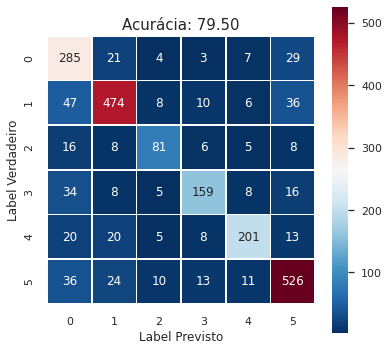

In [43]:
# Buscando todas as features do dataset apos o pre-processamento
all_features = [col for col in dados.columns if col != 'categoria']

# Separar target
X = dados[all_features]
y = dados['categoria']

# Aplicando a mesma escala nos dados
X = MinMaxScaler().fit_transform(X)

# Separação dos dados em um conjunto de treino e um conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preparando o dataset para o modelo
train_data = lgb2.Dataset(X_train, label=y_train, categorical_feature='auto', free_raw_data=False)
val_data   = lgb2.Dataset(X_test, label=y_test, categorical_feature='auto', free_raw_data=False)

lgb_params = {
    "objective"    : "multiclass",
    "metric"       : "multi_logloss",
    "verbosity"    : -1,
    "boosting_type": "gbdt",
    'num_class'    : 7
}

# Realizando o treinamento do modelo LGBM
modelo_lgb_v8 = lgb2.train(lgb_params, 
                           train_data, 
                           valid_sets=[train_data,val_data],
                           verbose_eval=100, 
                           early_stopping_rounds=100,)

# Previsões para cada classe com dados de teste
lgb_y_pred = np.rint(modelo_lgb_v8.predict(X_test, num_iteration=modelo_lgb_v8.best_iteration))

# Calcula o score com dados de teste
lgb_y_pred = [np.argmax(line) for line in lgb_y_pred]
lgb_score_v8 = accuracy_score(y_test, lgb_y_pred) * 100

# Print
print("Acurácia :", lgb_score_v8)

# Cria a matriz de confusão
conf_matriz_lgb = confusion_matrix(y_test, lgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_lgb = conf_matriz_lgb[0,0] / (conf_matriz_lgb[0,0] + conf_matriz_lgb[0,1])
sensi_lgb = conf_matriz_lgb[1,1] / (conf_matriz_lgb[1,0] + conf_matriz_lgb[1,1])

# Print
print('Sensibilidade :', sensi_lgb)
print('Especificidade :', speci_lgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_lgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(lgb_score_v8), size = 15)

# Relatório de Classificação
print(classification_report(y_test, lgb_y_pred))

# Exibindo os melhores parametros e desempenho do modelo
best_params = modelo_lgb_v8.params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

# Parte 07. Avaliação do Desempenho dos Modelos
> Nesta fase estarei comparando cada versao do modelo LightGBM

In [44]:
# Prepara a lista de resultados
metricas = [(lgb_score_v1),(lgb_score_v2),(lgb_score_v3),(lgb_score_v4),(lgb_score_v5),(lgb_score_v6),(lgb_score_v7),(lgb_score_v8)]

# Cria o dataframe
df_metricas = pd.DataFrame(metricas, 
                           columns = ['Accuracy'], 
                           index = ['Versao 01', 'Versao 02', 'Versao 03', 'Versao 04', 'Versao 05', 'Versao 06', 'Versao 07', 'Versao 08']) 

# Visualiza o resultado
df_metricas

Accuracy
Versao 01  79.871027
Versao 02  77.383694
Versao 03  82.302081
Versao 04  82.420749
Versao 05  85.734870
Versao 06  81.231988
Versao 07  83.753602
Versao 08  79.502533